# Explaining SIM City Mechanics

...with examples.

This notebook serves to illustrate how the environment calculates pollution / population gain for every tile. And how each city tile affects other city tile.

This is different from `eaxmple_run.ipynb` as this notebook has no agent involvement or even indicate how the simulation is run. This is strictly on the scoring system and how each tile affects each other.

**EDITED** Environment with stricter road placement and cluster connectivity is under "Road Restricted Environment" section (scroll all the way down)

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [2]:
#let's import our pre-requisites packages
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch, Rectangle

from environments.environment import CityModel
from update_rules.update_rules import DefaultUpdateRules, DefaultUpdateRulesParameters
from agents.agent import CityPlanner
from utils import TileTypes

In [3]:
tile_colours_map = {
    TileTypes.BARREN: "#eea5a5",
    TileTypes.RESIDENCE: "#ffeb3b",
    TileTypes.GREENERY: "#4caf50",
    TileTypes.INDUSTRY: "#9e9e9e",
    TileTypes.SERVICE: "#2196f3",
    TileTypes.ROAD: "#424242",
}

#in case I add any new tiles
assert(len(TileTypes)==len(tile_colours_map))

tile_colours = [tile_colours_map[t] for t in TileTypes]
tile_names = [t.name for t in TileTypes]

#visualise function that will be used here
def visulise_graph(model, precision=1):
    #go go go AI chatbot

    # Fetch arrays
    tile = model.grid.tile._mesa_data
    pop_g = model.grid.pop_g._mesa_data
    poll_g = model.grid.poll_g._mesa_data

    # Discrete colormap setup for tile (ensure order is 0..max_type)
    max_type = max([t.value for t in TileTypes])
    color_list = [tile_colours_map.get(t, "#000000") for t in TileTypes]
    tile_cmap = ListedColormap(color_list)
    # Boundaries s.t. integers map cleanly to categories
    bounds = np.arange(-0.5, max_type + 1.5, 1)
    tile_norm = BoundaryNorm(bounds, tile_cmap.N)

    # Create figure and axes
    # Layout: 2 rows (1 for tile, 1 for pop_g/poll_g)
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    ax_tile = fig.add_subplot(gs[0, :])
    im0 = ax_tile.imshow(tile, cmap=tile_cmap, norm=tile_norm, origin="upper", aspect="equal")
    ax_tile.set_title("Tile", fontsize=14)
    nx, ny = tile.shape
    ax_tile.set_xticks(np.arange(-0.5, ny, 1), minor=True)
    ax_tile.set_yticks(np.arange(-0.5, nx, 1), minor=True)
    ax_tile.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_tile.tick_params(which="minor", bottom=False, left=False)
    ax_tile.set_xticks([])
    ax_tile.set_yticks([])

    # Build legend patches for tile types that actually appear
    legend_handles = [
        Patch(facecolor=tile_colours_map[t], edgecolor="none", label=t.name)
        for t in TileTypes
    ]
    ax_tile.legend(
        handles=legend_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=len(legend_handles),  # one row
        frameon=False,
        title="Tile Types",
        fontsize=9,
        title_fontsize=10,
    )

    # --- Row 2: pop_g and poll_g ---
    ax_pop = fig.add_subplot(gs[1, 0])
    ax_poll = fig.add_subplot(gs[1, 1])

    # Population growth
    im1 = ax_pop.imshow(pop_g, cmap="viridis", origin="upper", aspect="equal")
    ax_pop.set_title("Population Growth (pop_g)", fontsize=12)
    ax_pop.set_xticks(np.arange(-0.5, pop_g.shape[0], 1), minor=True)
    ax_pop.set_yticks(np.arange(-0.5, pop_g.shape[1], 1), minor=True)
    ax_pop.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_pop.tick_params(which="minor", bottom=False, left=False)
    ax_pop.set_xticks([])
    ax_pop.set_yticks([])
    fig.colorbar(im1, ax=ax_pop, shrink=0.85, label="pop_g")

    for i in range(pop_g.shape[0]):
        for j in range(pop_g.shape[1]):
            val = float(pop_g[i, j])
            if val>0:
                ax_pop.text(
                    j, i, f"{val:.{precision}f}",
                    ha="center", va="center",
                    color="red", fontsize=8, fontweight="bold"
                )

    # Pollution growth
    im2 = ax_poll.imshow(poll_g, cmap="viridis", origin="upper", aspect="equal")
    ax_poll.set_title("Pollution Growth (poll_g)", fontsize=12)
    ax_poll.set_xticks(np.arange(-0.5, poll_g.shape[0], 1), minor=True)
    ax_poll.set_yticks(np.arange(-0.5, poll_g.shape[1], 1), minor=True)
    ax_poll.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax_poll.tick_params(which="minor", bottom=False, left=False)
    ax_poll.set_xticks([])
    ax_poll.set_yticks([])
    fig.colorbar(im2, ax=ax_poll, shrink=0.85, label="poll_g")
    for i in range(poll_g.shape[0]):
        for j in range(poll_g.shape[1]):
            val = float(poll_g[i, j])
            if val>0:
                ax_poll.text(
                    j, i, f"{val:.{precision}f}",
                    ha="center", va="center",
                    color="red", fontsize=8, fontweight="bold"
                )
    plt.tight_layout()
    plt.show()

def visualise_road_tiles(model):
    #go go go AI chatbot
    road_sets = model.road_sets
    nrows, ncols = road_sets.shape
    font_min=6; font_max=16
    base = min( max( int(min(nrows, ncols) and 36 / max(nrows, ncols) * 10), font_min), font_max )

    fig_w = min(18, max(6, ncols * 0.5))
    fig_h = min(18, max(4, nrows * 0.5))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    
    ax.set_title("Road sets", fontsize=base+2)
    # Draw cells as empty white rectangles with black borders
    ax.set_xlim(-0.5, ncols - 0.5)
    ax.set_ylim(nrows - 0.5, -0.5)  # origin='upper' to match NumPy [row, col]
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    # Cell borders
    for i in range(nrows):
        for j in range(ncols):
            ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="black", linewidth=0.6))

    # Text overlay (numbers only)
    for i in range(nrows):
        for j in range(ncols):
            v = road_sets[i, j]
            if v<=0:
                continue
            s = "nan" if np.isnan(v) else int(v)
            ax.text(j, i, s, ha="center", va="center", color="red", fontsize=base, fontweight="bold")

    plt.tight_layout()
    plt.show()

def visualise_tile_cluster(model):
    #go go go AI chatbot
    #note, model must be an object of CityModelStricterRoad!
    cluster_grids = [model.residence_cluster, model.greenery_cluster, 
                    model.industry_cluster, model.service_cluster]
    titles = ["Residence Cluster", "Greenery Cluster", "Industry Cluster", "Service Cluster"]
    
    road_tiles = model.road_tiles
    road_tiles = road_tiles>0
    # Use the first road_sets to determine dimensions (assuming all are same size)
    nrows, ncols = cluster_grids[0].shape
    font_min = 6
    font_max = 16
    base = min(max(int(min(nrows, ncols) and 36 / max(nrows, ncols) * 10), font_min), font_max)

    fig_w = min(18, max(6, ncols * 0.5))
    fig_h = min(18, max(4, nrows * 0.5))
    
    # Create 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(fig_w * 2, fig_h * 2))
    axes = axes.flatten()  # Flatten to iterate easily
    
    for idx, (cluster_grid, ax) in enumerate(zip(cluster_grids, axes)):
        ax.set_title(titles[idx], fontsize=base + 2)
        
        # Draw cells as empty white rectangles with black borders
        ax.set_xlim(-0.5, ncols - 0.5)
        ax.set_ylim(nrows - 0.5, -0.5)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Cell borders
        for i in range(nrows):
            for j in range(ncols):
                ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="black", linewidth=0.6))

        for i in range(nrows):
            for j in range(ncols):
                # Check if this cell should be shaded
                if road_tiles[i, j]:
                    # Shaded cell (gray fill)
                    ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, 
                                          fill=True, facecolor="lightgray", 
                                          edgecolor="black", linewidth=0.6))
                else:
                    # Normal cell (white fill)
                    ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, 
                                          fill=False, edgecolor="black", linewidth=0.6))


        # Text overlay (numbers only)
        for i in range(nrows):
            for j in range(ncols):
                v = cluster_grid[i, j]
                if v <= 0:
                    continue
                s = "nan" if np.isnan(v) else int(v)
                ax.text(j, i, s, ha="center", va="center", color="red", fontsize=base, fontweight="bold")

    plt.tight_layout()
    plt.show()

In [4]:
#let's create our environment first
# with open("data/update_parameters/DefaultUpdateRule.json") as f:
#     default_rule_parameters = json.load(f)
    
#to keep things very consistent throughout, let's use predefined values. Makes it easier to change as well
default_rule_parameters = {
  "residence_population_increase": 30,
  "residence_poll_g": 1.5,
  "residence_pop_g": 1,
  "residence_walking_distance": 1,
  
  "greenery_poll_minus": 0.05,
  "greenery_pop_g": 2,
  "greenery_coverage": 2,
  
  "industry_poll_g": 1,
  "industry_pop_g": 8,
  "industry_coverage": 2,
  "industry_connectivity_initial_modifier": 0.02,
  "industry_connectivity_cap": 10,

  "service_poll_g": 5.0,
  "service_pop_g": 4.0,
  "service_pop_modifier": 0.2,
  "service_coverage": 2,
  "service_connectivity_initial_modifier":0.05,
  "service_connectivity_cap": 5,
  
  "road_poll_g": 1,
  "road_pop_g": 0.5
}

default_rule_parameters = DefaultUpdateRulesParameters(**default_rule_parameters)

# define the class with empty parameters and set the parameters thereafter. 
# In case for extensions, one can override the parameters
update_rules = DefaultUpdateRules()
update_rules.set_parameters(default_rule_parameters)

#shouldn't do this but since we are not using any agent in the first place
width = 16
height = 16
model = CityModel(CityPlanner, width, height, update_rules, collect_rate=1.0)

## The Basics

We want to do urban planning with sustainability in mind. To this mind, we have an urban city discretised into a grid. For each turn, we will place a city tile on the grid, depending on the type of tile, it will produce pollution and/or population. The objective is to maximise population, and minimise pollution.

In the beginning, we have nothing but Barren land which produces 0 pollution and population.

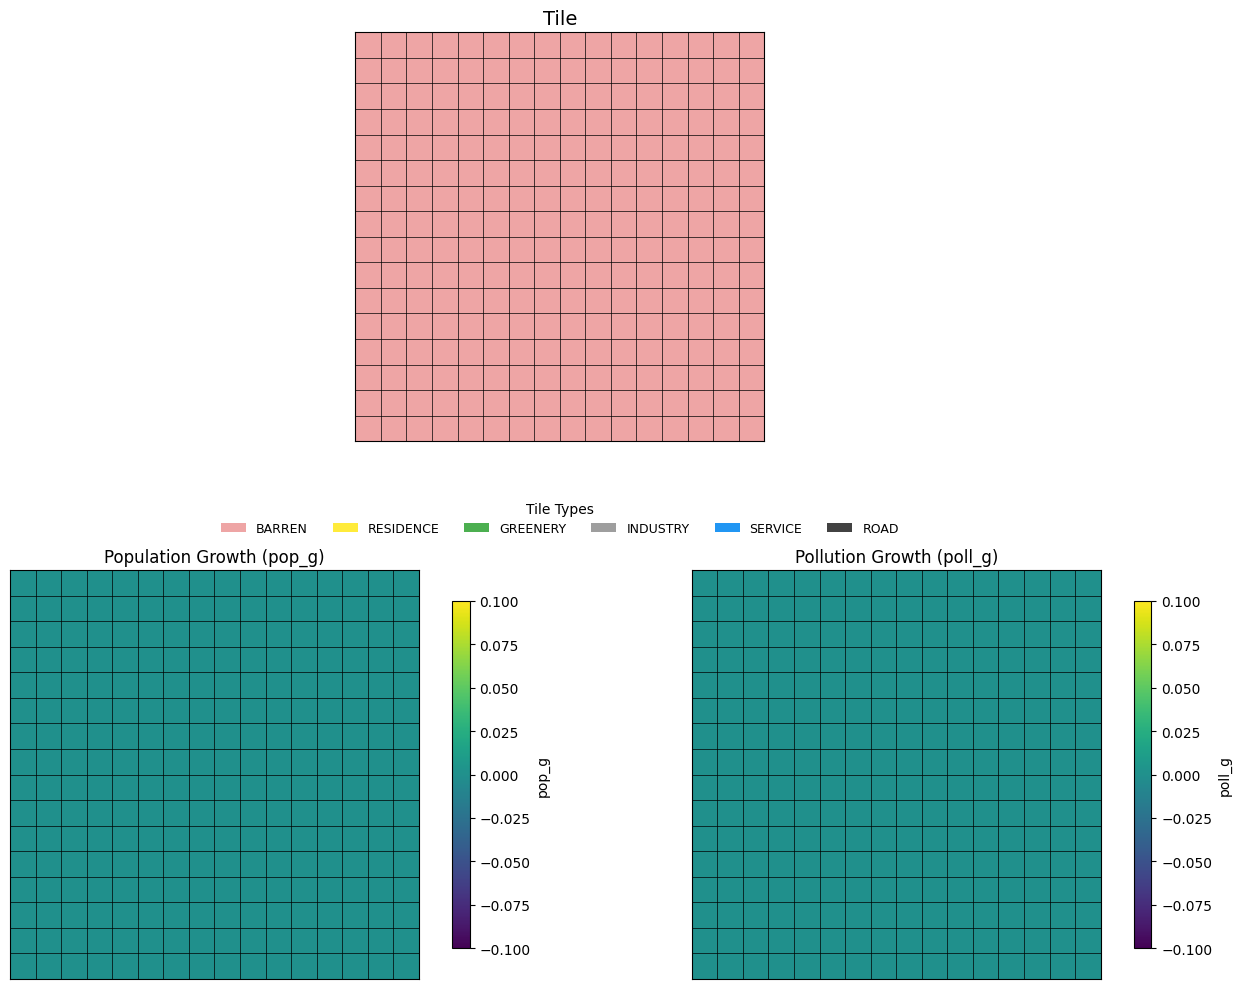

In [5]:
visulise_graph(model)

## Residence 

Residence tile represents liveability of a city. They produce population and pollution, their main function is to increase the population cap of the city. If your population cap is too low, the total population will be capped. 

Let's add some residence tiles around. Note in the simulation, each tile is placed at a time.

In [6]:
model.set_tile(2, 3,TileTypes.RESIDENCE.value)
model.set_tile(5, 12,TileTypes.RESIDENCE.value)
model.set_tile(12, 2,TileTypes.RESIDENCE.value)
model.set_tile(10, 10,TileTypes.RESIDENCE.value)
model.set_tile(7, 6,TileTypes.RESIDENCE.value)
model.set_tile(11, 3,TileTypes.RESIDENCE.value)

#this method must be invoked as it will consolidate the different tiles into seperate binary 
#numpy array
model.book_keep()

# we will need to invoke the update rules to update the population / pollution gain
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)
print(f"Current Population cap: {population_cap}")

Current Population cap: 180.0


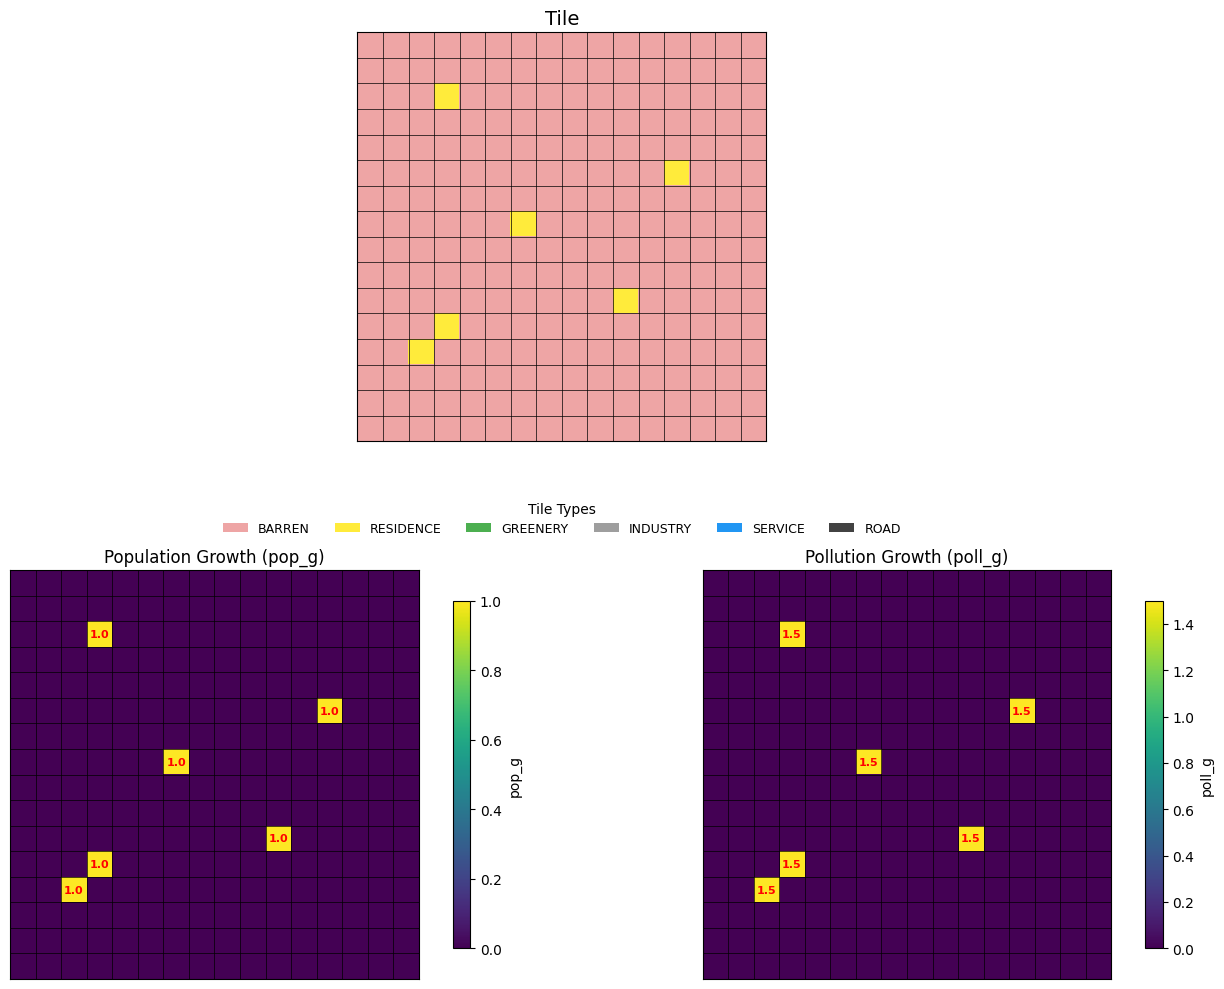

In [7]:
visulise_graph(model)

## Road

Road represent amenities and connectivity within the city. Roads don't produce much population but it produces quite a bit pollution. The main function of the road is to connect Residence tiles to Service and Industry tiles. Road tiles are connected only via **top, bottom, left and right neighbours (not adjacent)**. Each connected road tiles will form a network so it is possible to have different networks that are disconnected.

In [8]:
# let's add some preliminary network

model.set_tile(12, 6,TileTypes.ROAD.value)
model.set_tile(12, 5,TileTypes.ROAD.value)
model.set_tile(12, 4,TileTypes.ROAD.value)
model.set_tile(12, 3,TileTypes.ROAD.value)
model.set_tile(10, 8,TileTypes.ROAD.value)
model.set_tile(10, 7,TileTypes.ROAD.value)
model.set_tile(10, 6,TileTypes.ROAD.value)
model.set_tile(9, 6,TileTypes.ROAD.value)
model.set_tile(8, 10,TileTypes.ROAD.value)
model.set_tile(8, 11,TileTypes.ROAD.value)
model.set_tile(8, 12,TileTypes.ROAD.value)
model.set_tile(8, 13,TileTypes.ROAD.value)
model.set_tile(7, 14,TileTypes.ROAD.value)
model.set_tile(6, 14,TileTypes.ROAD.value)
model.set_tile(5, 14,TileTypes.ROAD.value)
model.set_tile(4, 14,TileTypes.ROAD.value)
model.set_tile(3, 8,TileTypes.ROAD.value)
model.set_tile(2, 8,TileTypes.ROAD.value)
model.set_tile(2, 7,TileTypes.ROAD.value)
model.set_tile(2, 6,TileTypes.ROAD.value)
model.set_tile(2, 5,TileTypes.ROAD.value)
model.set_tile(2, 4,TileTypes.ROAD.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

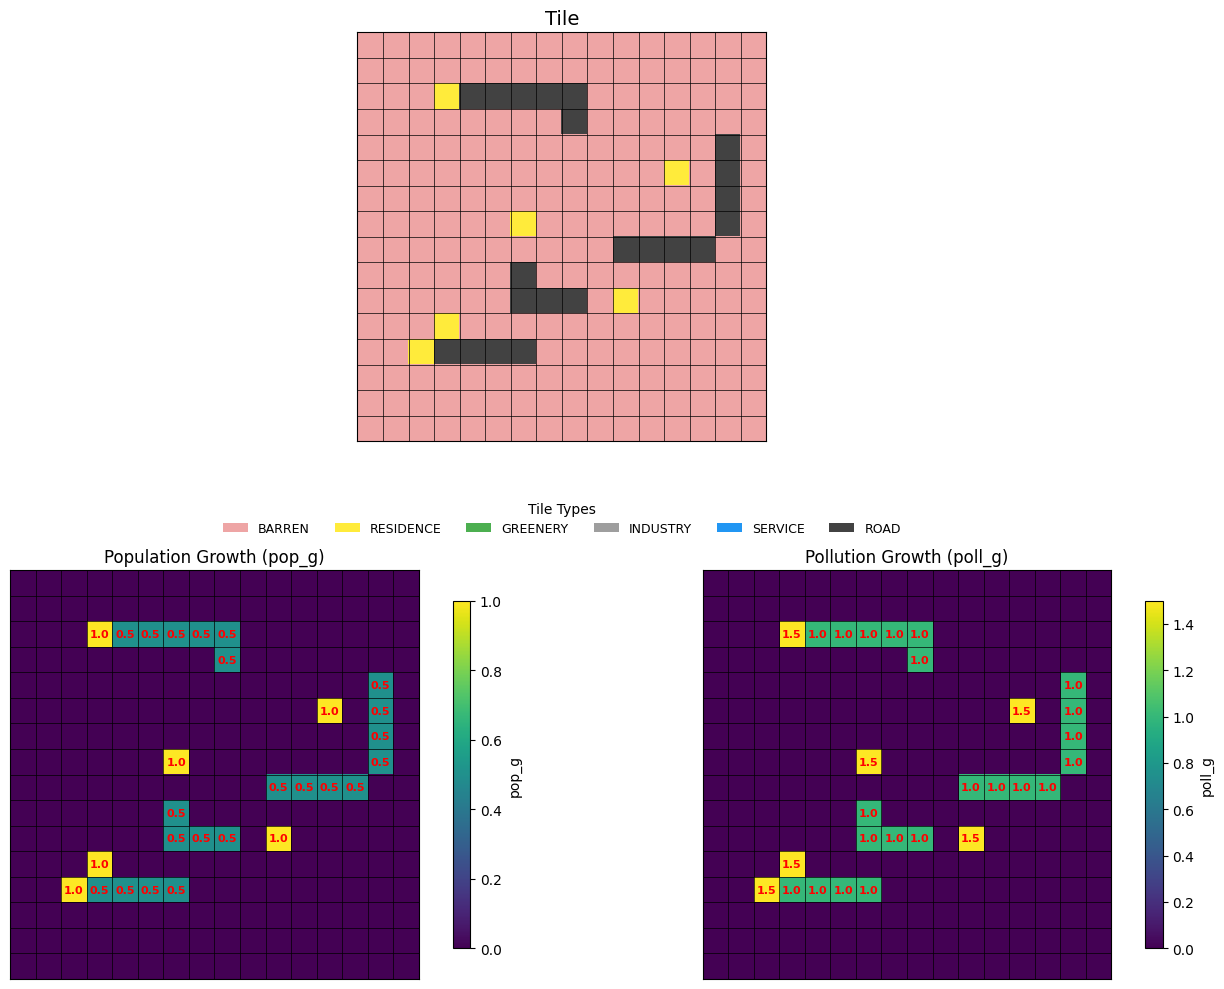

In [9]:
visulise_graph(model)

We can also visualise its road "network" as well. Network in quotes because it's really more of assigning ids to each road tiles. Tile with the same id belongs to the same network. You will note that roads that are diagonal to each other are not counted (Road network 3 and 4)

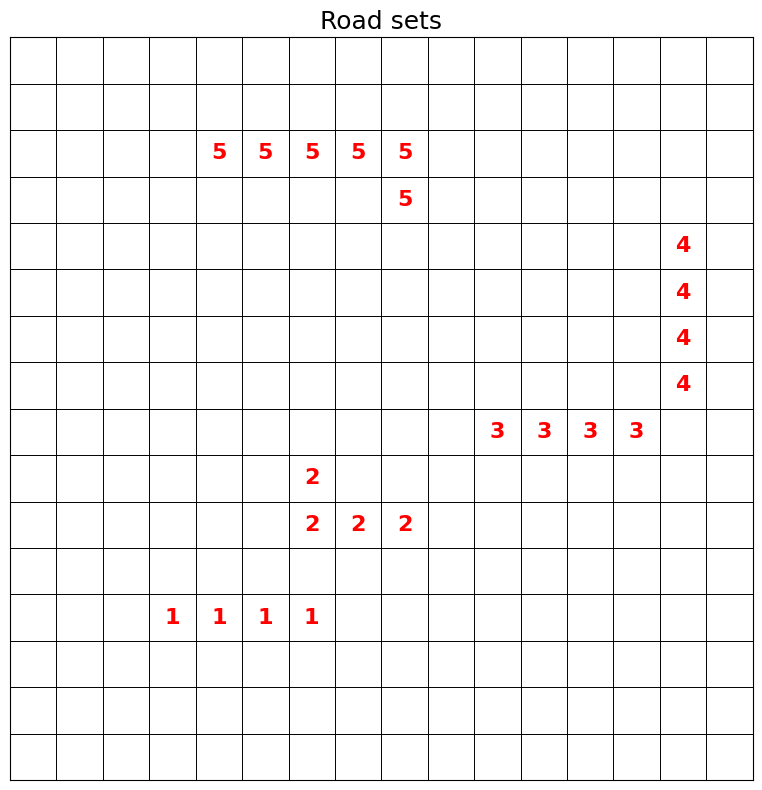

In [10]:
visualise_road_tiles(model)

Road networks can be merged. Smaller networks are subsumed into bigger network. Let's first add one more road time to network 4. Then merge 3 and 4 together

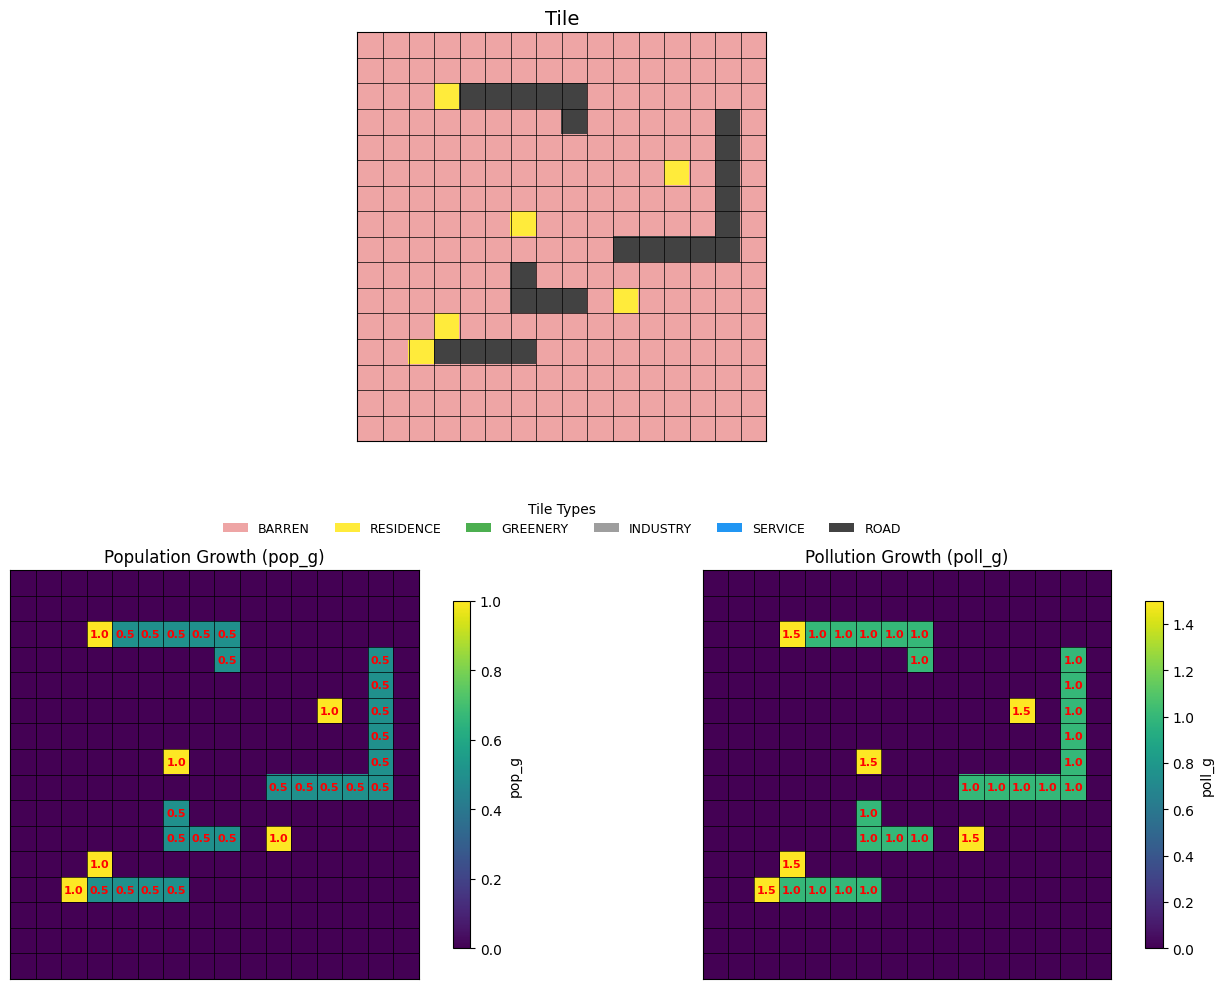

In [11]:
model.set_tile(3, 14,TileTypes.ROAD.value)
model.set_tile(8, 14,TileTypes.ROAD.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model)

Visualising the road IDs, we can see that 3 is gone and merged into 4 as it has more road tiles.

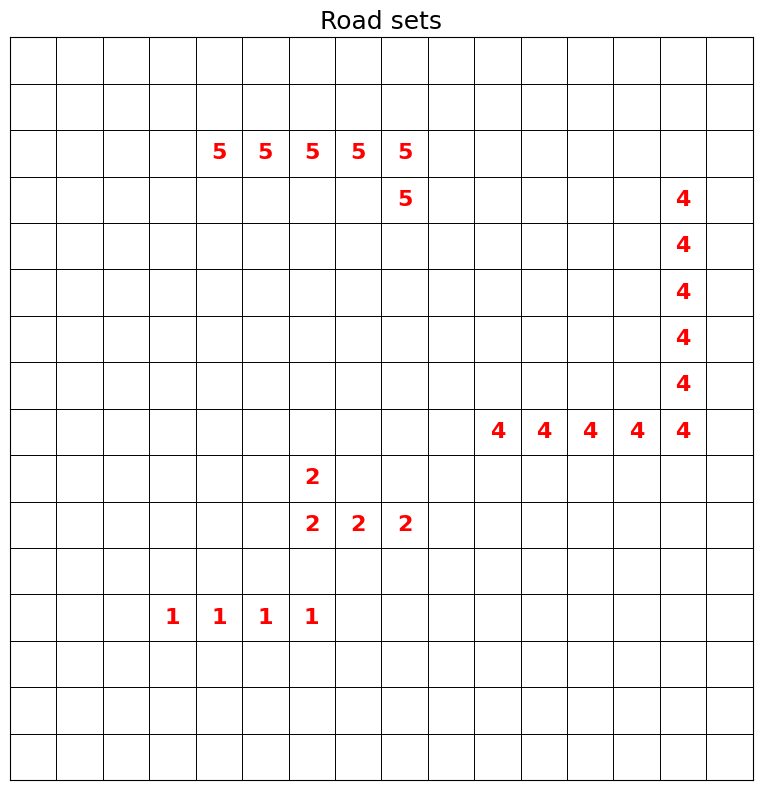

In [12]:
visualise_road_tiles(model)

### Road connectivity

Under the hood, the environment will keep track which Residence tiles are connected to which Road network. During merging, residences associated with smaller road networks will be associated with the larger network as well. Note, a resident tile can also be associated with multiple road networks. 

## Services

Services represent amenities, this could range from entertainment to essential services. They boost population and contribute quite a bit to pollution. Services require connections to residence in order to be 'productive', in this case reach its 100% population and pollution contribution.

Below, show how population and pollution of each service tile is calculated. 

$Population(service\ tile) = (x_{service} + \frac{1-x_{service}}{s_{cap}} \cdot r_{s_c}) \cdot s_{pop}$

$Pollution(service\ tile) = (x_{service}  + \frac{1-x_{service}}{s_{cap}} \cdot r_{s_c}) \cdot s_{poll}$

where:
- $x<1$, this is defined under `service_connectivity_initial_modifier` in the rule parameters
- $s_{pop}$ and $s_{poll}$ are a service tile's base value for population and pollution respectively. `service_pop_g` and `service_poll_g` under rule parameters respectively.
- $s_{cap}$ is the number of residence tiles needed before a tile reach 100% 'productivity'. Defined under `service_connectivity_cap` under rule parameters.
- $r_{s_c}$ is the number of residence tiles currently connected via roads _and_ any residences within walking distance. 
- Typically, $x<\frac{1-x_{service}}{s_{cap}}$

Note:
- this means if there are no Residence tiles connected, it is simply $x\cdot s_{pop}$  and $x\cdot s_{poll}$  
- when $r_c = s_{cap}$, $Population(service\ tile) = s_{pop}$, thus, 100% productivity.
- when $r_c > s_{cap}$, the service tile becomes more productive which produces more population and pollution.

A special thing about services tile is that is boost surrounding Residence tiles to simulate that these residences are attractive as they are near such amenities. Surrounding residences in this case depends on the `service_coverage` and the `service_pop_modifier`. This modifier stacks! So more services surrounding residences will have higher modifiers!

Let's define some service tiles.


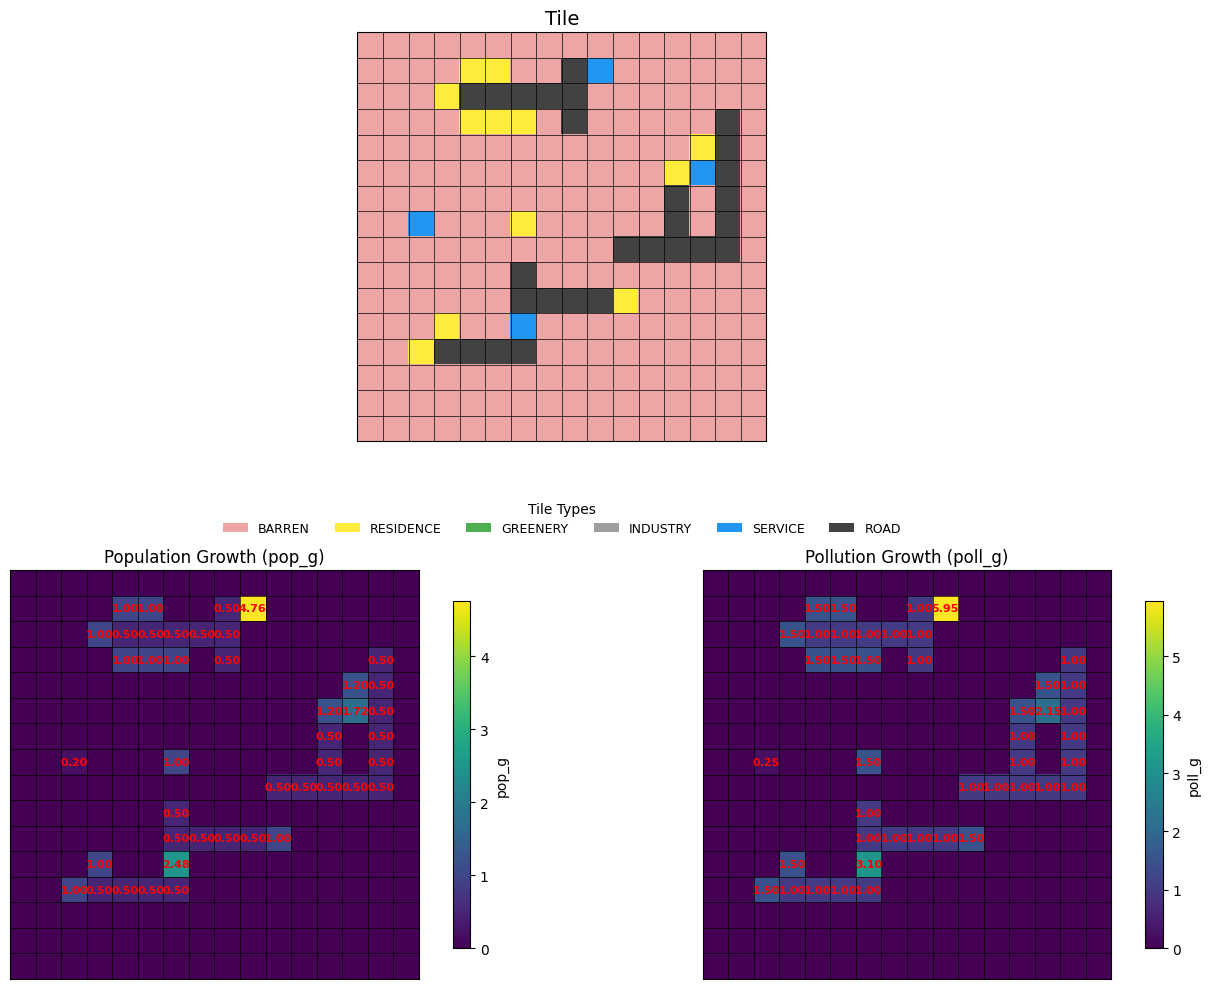

In [13]:
#let's complete some network first
model.set_tile(7, 12,TileTypes.ROAD.value)
model.set_tile(6, 12,TileTypes.ROAD.value)
model.set_tile(10, 9,TileTypes.ROAD.value)
model.set_tile(4, 13,TileTypes.RESIDENCE.value)

model.set_tile(11, 6,TileTypes.SERVICE.value)
model.set_tile(5, 13,TileTypes.SERVICE.value)
model.set_tile(7, 2,TileTypes.SERVICE.value)

#let's add a very well connected residence
model.set_tile(3, 6,TileTypes.RESIDENCE.value)
model.set_tile(3, 5,TileTypes.RESIDENCE.value)
model.set_tile(3, 4,TileTypes.RESIDENCE.value)
model.set_tile(1, 5,TileTypes.RESIDENCE.value)
model.set_tile(1, 4,TileTypes.RESIDENCE.value)
model.set_tile(1, 8,TileTypes.ROAD.value)
model.set_tile(1, 9,TileTypes.SERVICE.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model, precision=2)

As you can see above, the only service tile that is standalone only produces $0.05 \times 4=0.2$ population, whereas the other two services are each connected to two residences:  $(0.05+\frac{1-0.05}{5} \times 2 \times 4)=1.7$.The same applies to pollution albeit with different pollution base.

We can also see that some residence tiles have improved population yield with `service_pop_modifier=1.2` and `service_coverage=2`. The two residence tiles at the upper right have $1\times 1.2=1.2$ population compared to other residence of $1.0$ population.

The one service tile connected to 6 residence tiles has a yield of $(0.05+\frac{1-0.05}{5} \times 6 \times 4)=4.76$ population

## Industry

Industry represents job opportunities of the city. They produce the greatest amount of population but also pollution. Like services, their productivity depends on how well connected they are, and in fact follow the same formula albeit governed by their own parameter

$Population(industry\ tile) = (x_{industry} + \frac{1-x_{industry}}{i_{cap}} \cdot r_{i_c}) \cdot i_{pop}$

$Pollution(industry\ tile) = (x_{industry} + \frac{1-x_{industry}}{i_{cap}} \cdot r_{i_c}) \cdot i_{poll}$


Industry has a special mechanics where its pollution spread across surrounding cell defined by `industry_coverage`. Thus $Pollution(industry\ tile)$ defines the pollution of __each__ cell so do take note when tweaking `industry_poll_g`

Like service tiles, the more residence connected, the more productive the industry tile. 

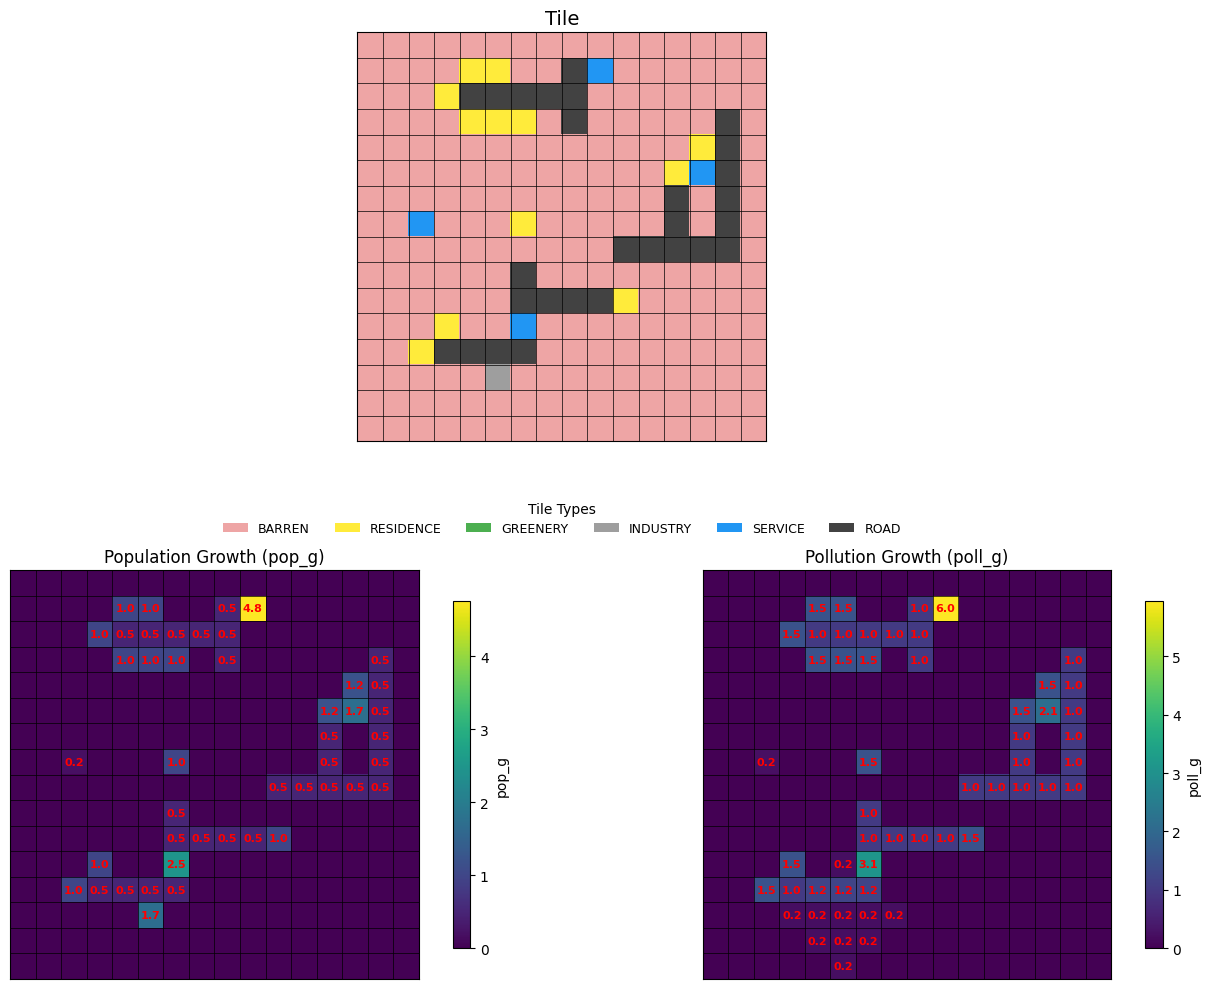

In [14]:
model.set_tile(13, 5,TileTypes.INDUSTRY.value)

model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model)

In the above example:

$Pollution(industry\ tile) = (x_{industry} + \frac{1-x_{industry}}{i_{cap}} \cdot r_{i_c}) \cdot i_{poll}$

- $x_{industry}=0.02$
- $i_{cap}=10$
- $i_{poll}=1$
- $r_{i_c} = 2$

Thus, $Pollution(industry\ tile) = 0.216$

With `industry_coverage=2`, we see a cross-shaped like spread, with each tile having pollution of 0.216. Note also the pollution gain is added to the road tiles. 

## Greenery

Greenery tile represents the livability of the city and is also the only mechanism to mitigate pollution. They also add to population.

The pollution is mitigated after all population is calculated (basically greenery is the last to calculate for pollution). The formula is as followed:

$Pollution(tile)\cdot\frac{1}{(1+\sum_n g_p)}$

Where:
- $g_p$ is defined under `greenery_poll_minus`, $0<g_p<1,$ 
- $n$ is the number of overlapping coverage. So if two greenery covers a tile, $n=2$. Coverage is determined by `greenery_coverage`

Basically, the more greenery overlaps on a tile, the more pollution it mititgates. Note that it will never be less than 0.

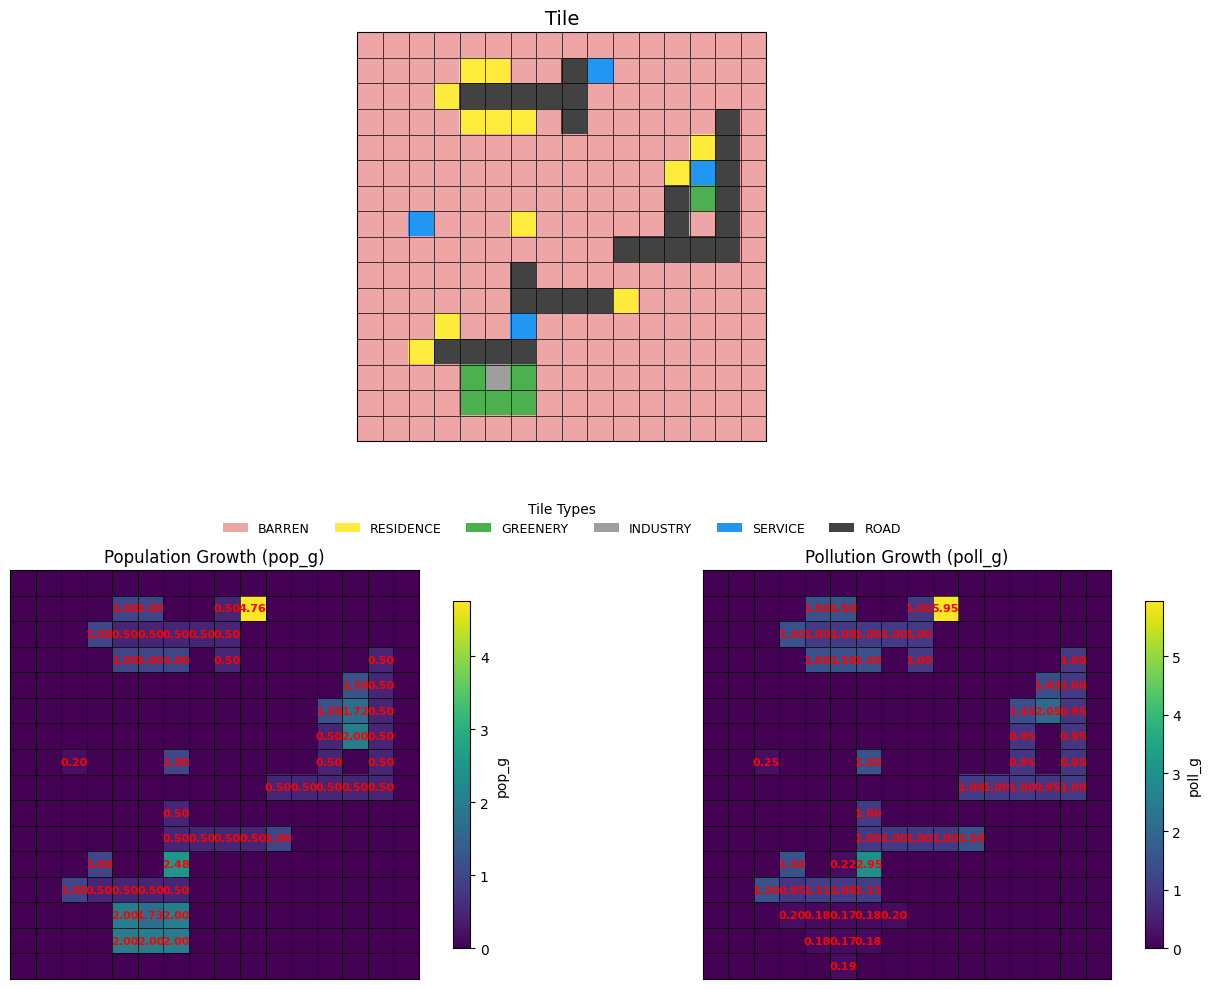

In [15]:
model.set_tile(13, 4,TileTypes.GREENERY.value)
model.set_tile(13, 6,TileTypes.GREENERY.value)
model.set_tile(14, 4,TileTypes.GREENERY.value)
model.set_tile(14, 6,TileTypes.GREENERY.value)
model.set_tile(14, 4,TileTypes.GREENERY.value)
model.set_tile(14, 5,TileTypes.GREENERY.value)
model.set_tile(6, 13,TileTypes.GREENERY.value)
model.book_keep()
population_cap, curr_pop_g, curr_poll_g = model.update_rules.apply_rules(model)

visulise_graph(model, precision=2)

# Road Restricted Environment

This a modified environment where connectivity and road placement is stricter

The general rule is as followed:

- Agent cannot place road tiles unless they are adjacent to another road tile. This necessitates the initial grid to have 1 road tile placed.
- 0 walkability, residences adjacent to any services are not considered connected unless they are connected with another road.
- Clustering: service/industry/greenery/residence clustered with the same type (adjacent to each other) share connectivity.
- Tiles that are not adjacent to road are considered not activated - 0 productivity / 0 pollution

In [16]:
# import the new environment

from environments.environment_stricter_road import CityModelStricterRoad
from update_rules.update_rules_stricter_road import UpdateRulesStricterRoad

In [17]:
default_rule_parameters = {
  "residence_population_increase": 30,
  "residence_poll_g": 1.5,
  "residence_pop_g": 1,
  "residence_walking_distance": 0, #we keep this to zero
  
  "greenery_poll_minus": 0.9,
  "greenery_pop_g": 2,
  "greenery_coverage": 2,
  
  "industry_poll_g": 1,
  "industry_pop_g": 8,
  "industry_coverage": 2,
  "industry_connectivity_initial_modifier": 0, # we keep this to zero as well
  "industry_connectivity_cap": 10,

  "service_poll_g": 5.0,
  "service_pop_g": 4.0,
  "service_pop_modifier": 0.2,
  "service_coverage": 2,
  "service_connectivity_initial_modifier":0,# we keep this to zero as well
  "service_connectivity_cap": 5,
  
  "road_poll_g": 1,
  "road_pop_g": 0.5
}

default_rule_parameters = DefaultUpdateRulesParameters(**default_rule_parameters)

# define the class with empty parameters and set the parameters thereafter. 
# In case for extensions, one can override the parameters
update_rules = UpdateRulesStricterRoad()
update_rules.set_parameters(default_rule_parameters)

#shouldn't do this but since we are not using any agent in the first place
width = 16
height = 16

## Stricter Road Rules

Because we can only add road next to other road, we will need to seed it first. We must supply where the initial road tile is. The initial road tile must be by the edge of the grid.

### Manually setting the road tile

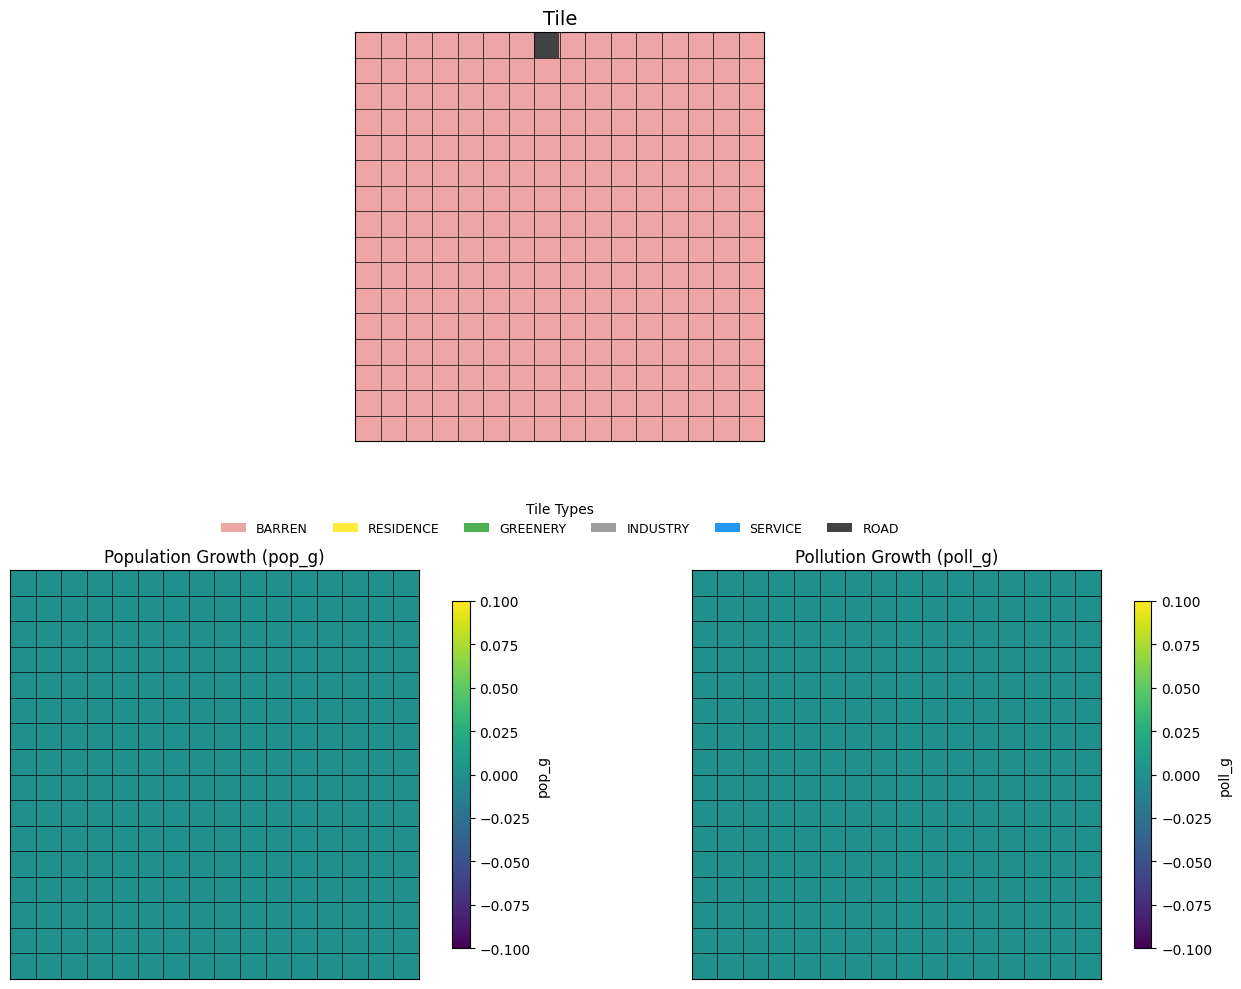

In [18]:
init_road_tile = (0,7)
model = CityModelStricterRoad(CityPlanner, width, height, update_rules, 
                                init_road_tile=init_road_tile, collect_rate=1.0)
model.book_keep()

visulise_graph(model)

### Or we can just randomnise it

Random init tile: (15, 2)


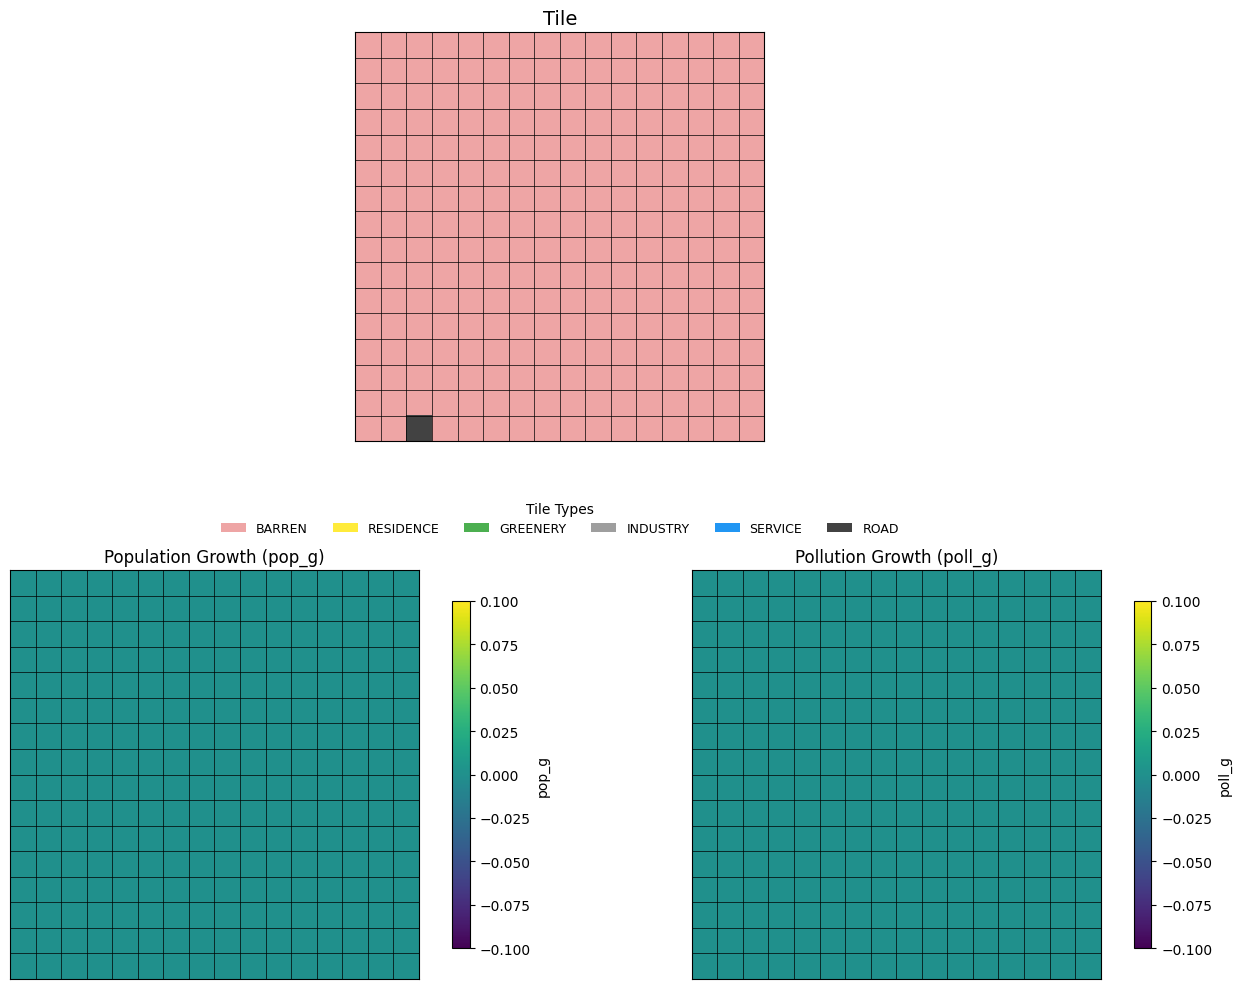

In [19]:
# we can get a sample.
# seed here only affects a local `Random` object so if you have set another seed, this will not affect it
rand_init_road_tile = CityModelStricterRoad.get_random_init_road_tile(width, height, seed=2025)
print("Random init tile:", rand_init_road_tile)
model = CityModelStricterRoad(CityPlanner, width, height, update_rules, 
                                init_road_tile=rand_init_road_tile, collect_rate=1.0)
model.book_keep()

visulise_graph(model)

In [20]:
# for the sake of consistency, let's set it to (0,7)

init_road_tile = (0,7)
model = CityModelStricterRoad(CityPlanner, width, height, update_rules, 
                                init_road_tile=init_road_tile, collect_rate=1.0)

## Illegal and Legal Road Tiles

If an agent tries to add any road tiles that are not adjacent, the environment will throw a fit. You can get a set of legal road tiles from the environment and choose from there.

<class 'RuntimeError'>
Invalid road placements for ROAD tile!
Legal road tiles
[[0 6]
 [0 8]
 [1 7]]
Setting [0 6]


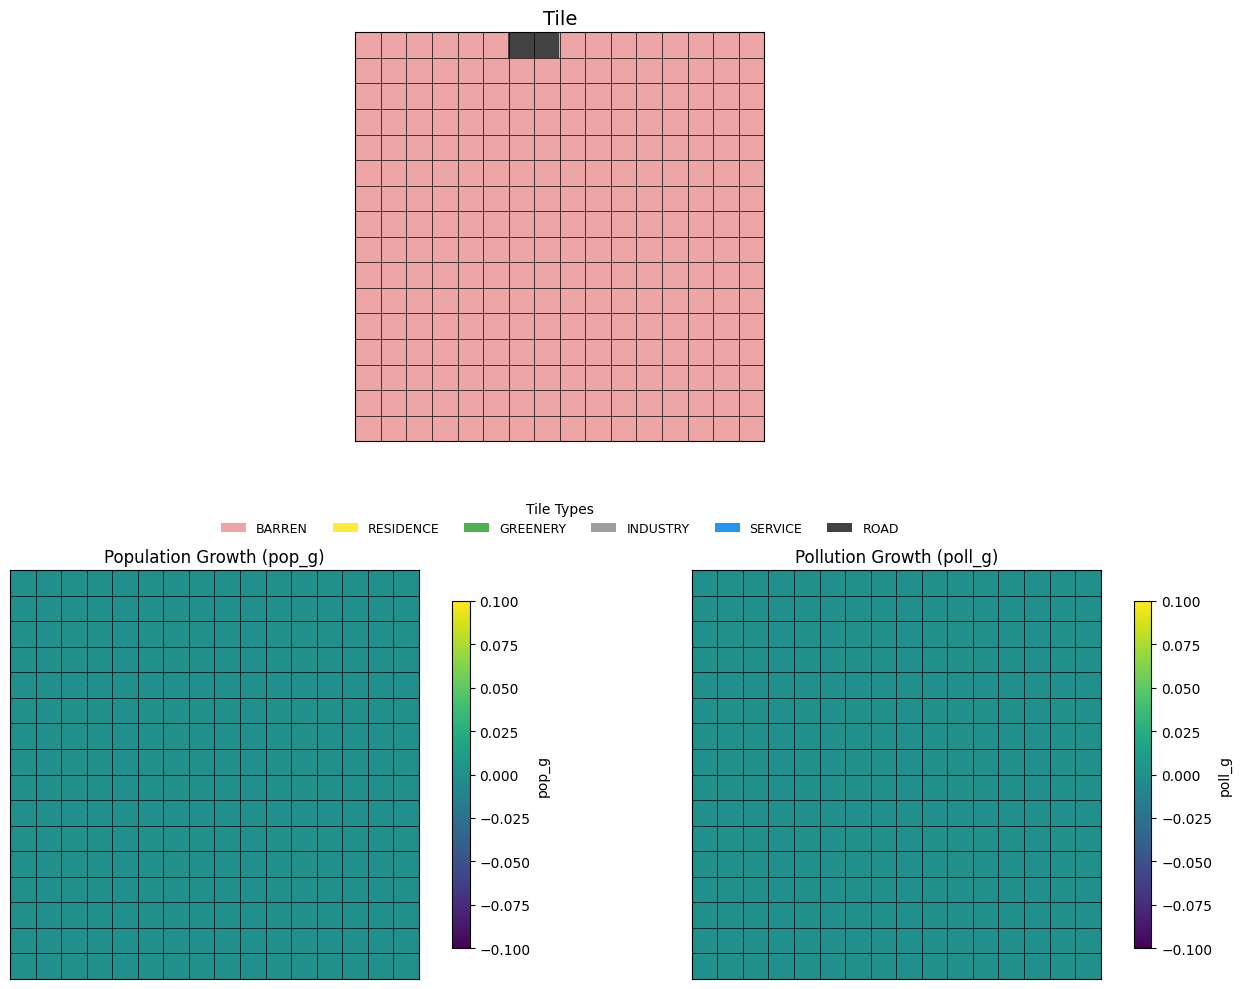

In [21]:
#adding illegal moves
try:
    model.set_tile(7,7, TileTypes.ROAD.value)
except RuntimeError as r:
    print(type(r))
    print(r)

#you can get a list of valid road tiles at any time
legal_road_tiles = model.get_legal_road_tiles()
print("Legal road tiles")
print(legal_road_tiles)

#add a legal road tile
print("Setting", legal_road_tiles[0])
row_x, col_y = legal_road_tiles[0]
model.set_tile(row_x,col_y, TileTypes.ROAD.value)
model.book_keep()

visulise_graph(model)

## Clustering of Service / Industry / Residence / Greenery

Tiles can have their own cluster, if a tile within a cluster is adjacent to a road tile, the whole cluster is considered as connected. Adjacencies in the cluster is defined by von-nuemann neighbour, (up, down, left, right) but not diagonals.

Note, unlike the previous environment, there is no notion of road network since there is only 1 road network

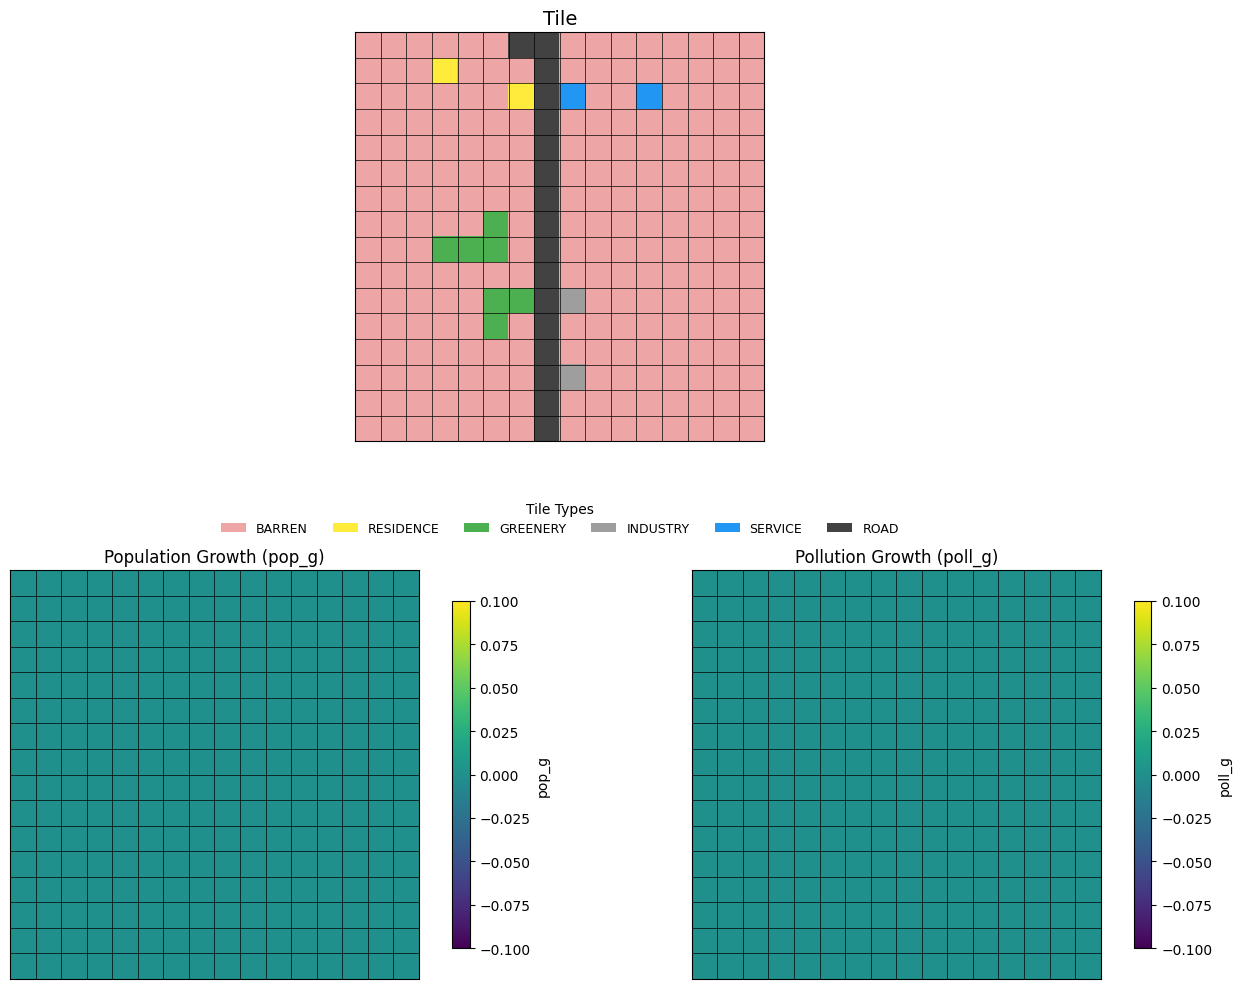

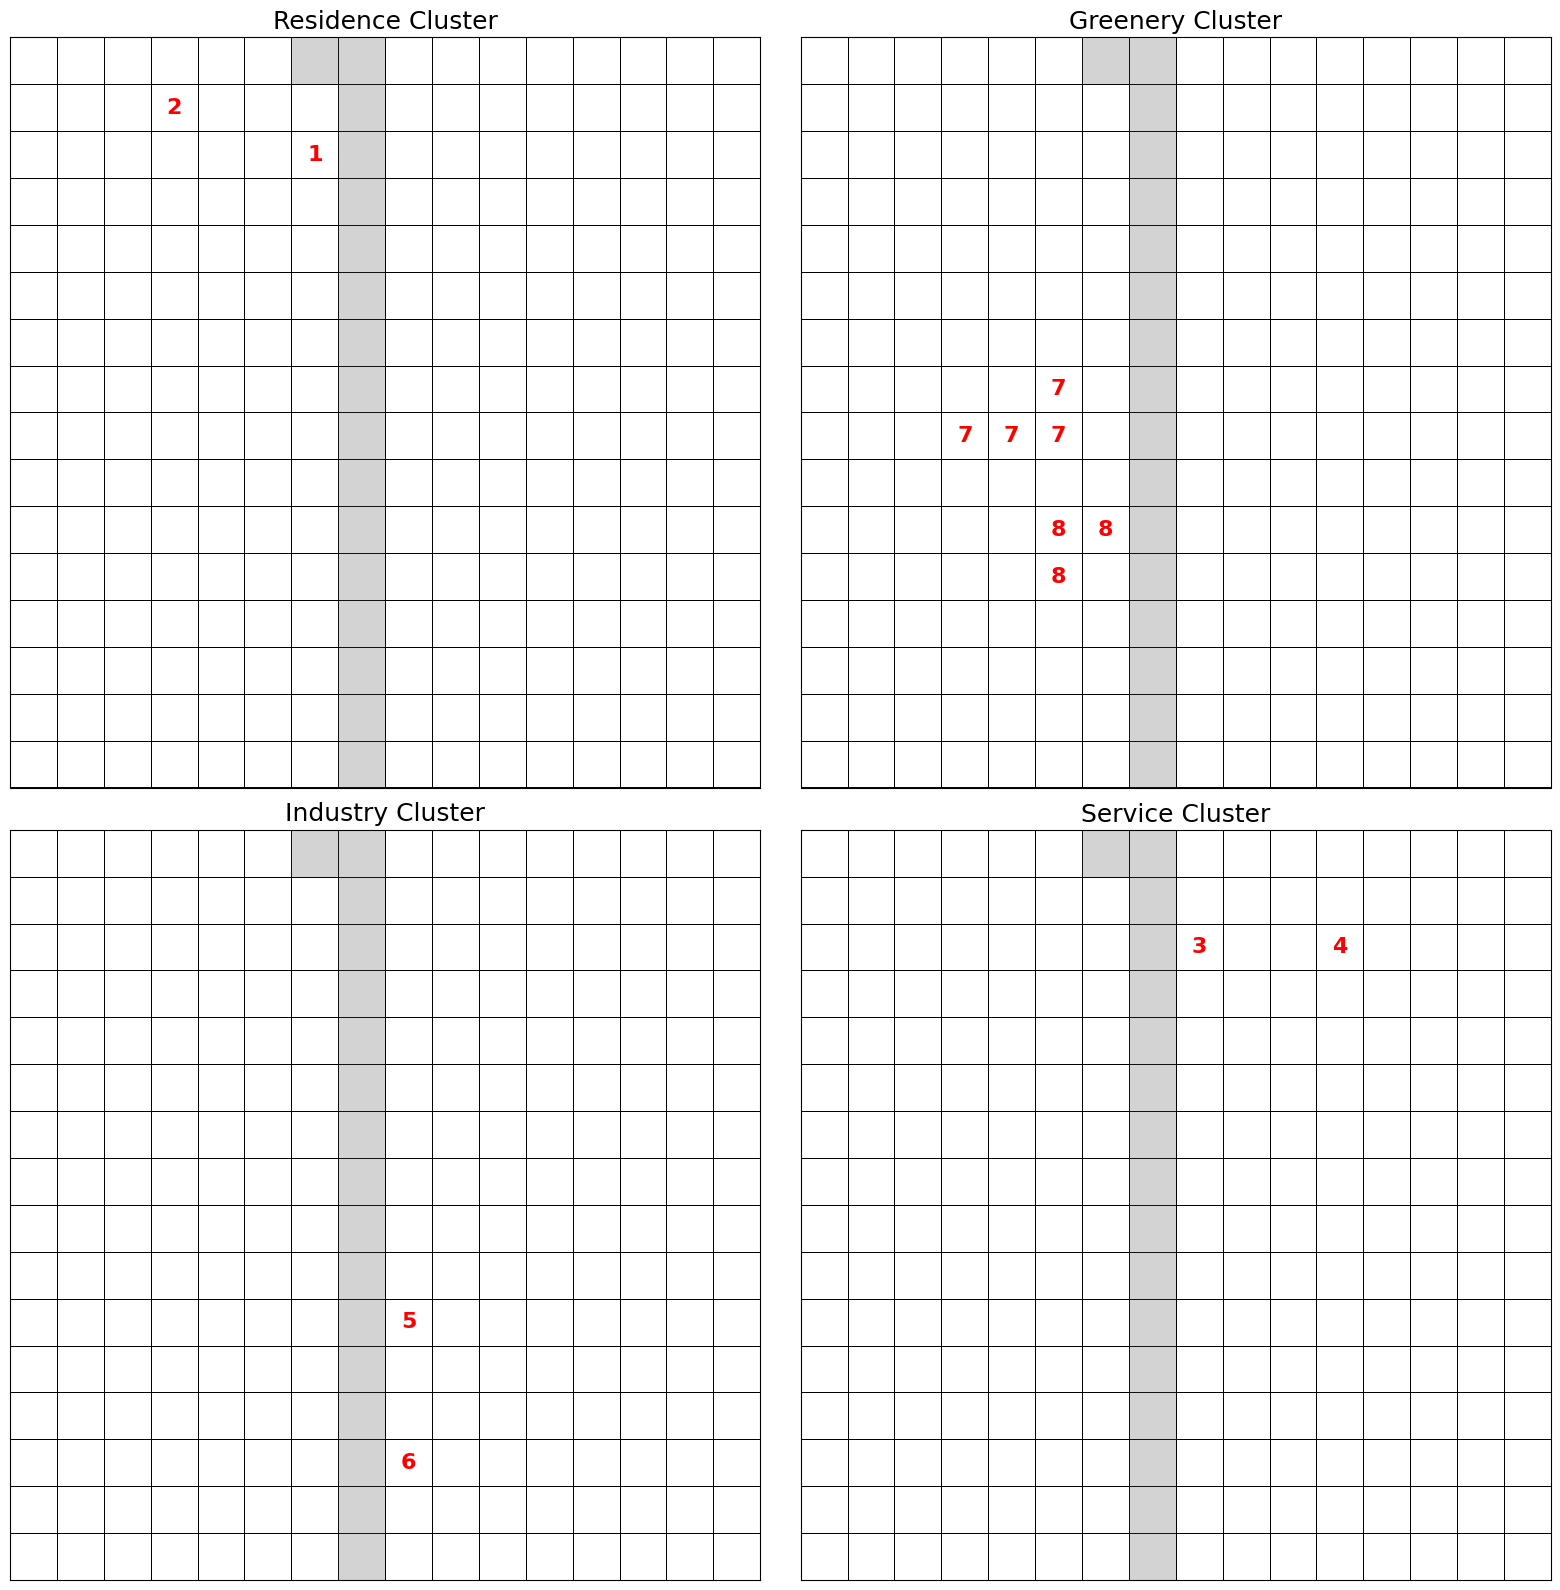

Clusters connected to road
{1, 3, 5, 6, 8}


In [22]:
#let's create add some road first

for c in range(1, width):
    model.set_tile(c,7, TileTypes.ROAD.value)
    model.book_keep()

#let's create some cluster
model.set_tile(2,6, TileTypes.RESIDENCE.value)
model.book_keep()
model.set_tile(1,3, TileTypes.RESIDENCE.value)
model.book_keep()
model.set_tile(2,8, TileTypes.SERVICE.value)
model.book_keep()
model.set_tile(2,11, TileTypes.SERVICE.value)
model.book_keep()
model.set_tile(10,8, TileTypes.INDUSTRY.value)
model.book_keep()
model.set_tile(13,8, TileTypes.INDUSTRY.value)
model.book_keep()

#create a bigger cluster
model.set_tile(8,5, TileTypes.GREENERY.value)
model.book_keep()
model.set_tile(7,5, TileTypes.GREENERY.value)
model.book_keep()
model.set_tile(8,4, TileTypes.GREENERY.value)
model.book_keep()
model.set_tile(8,3, TileTypes.GREENERY.value)
model.book_keep()

#create a smaller cluster
model.set_tile(10,6, TileTypes.GREENERY.value)
model.book_keep()
model.set_tile(11,5, TileTypes.GREENERY.value)
model.book_keep()
model.set_tile(10,5, TileTypes.GREENERY.value)
model.book_keep()

visulise_graph(model)
visualise_tile_cluster(model)

#we can also see what clusters are connected to road
print("Clusters connected to road")
print(model.cluster_adjacent_to_road)

 Note that cluster 7 is not connected to road and this is reflected.

 Similar to road network in the base environment, a bigger cluster will subsume a smaller cluster when a tile is placed between two clusters.

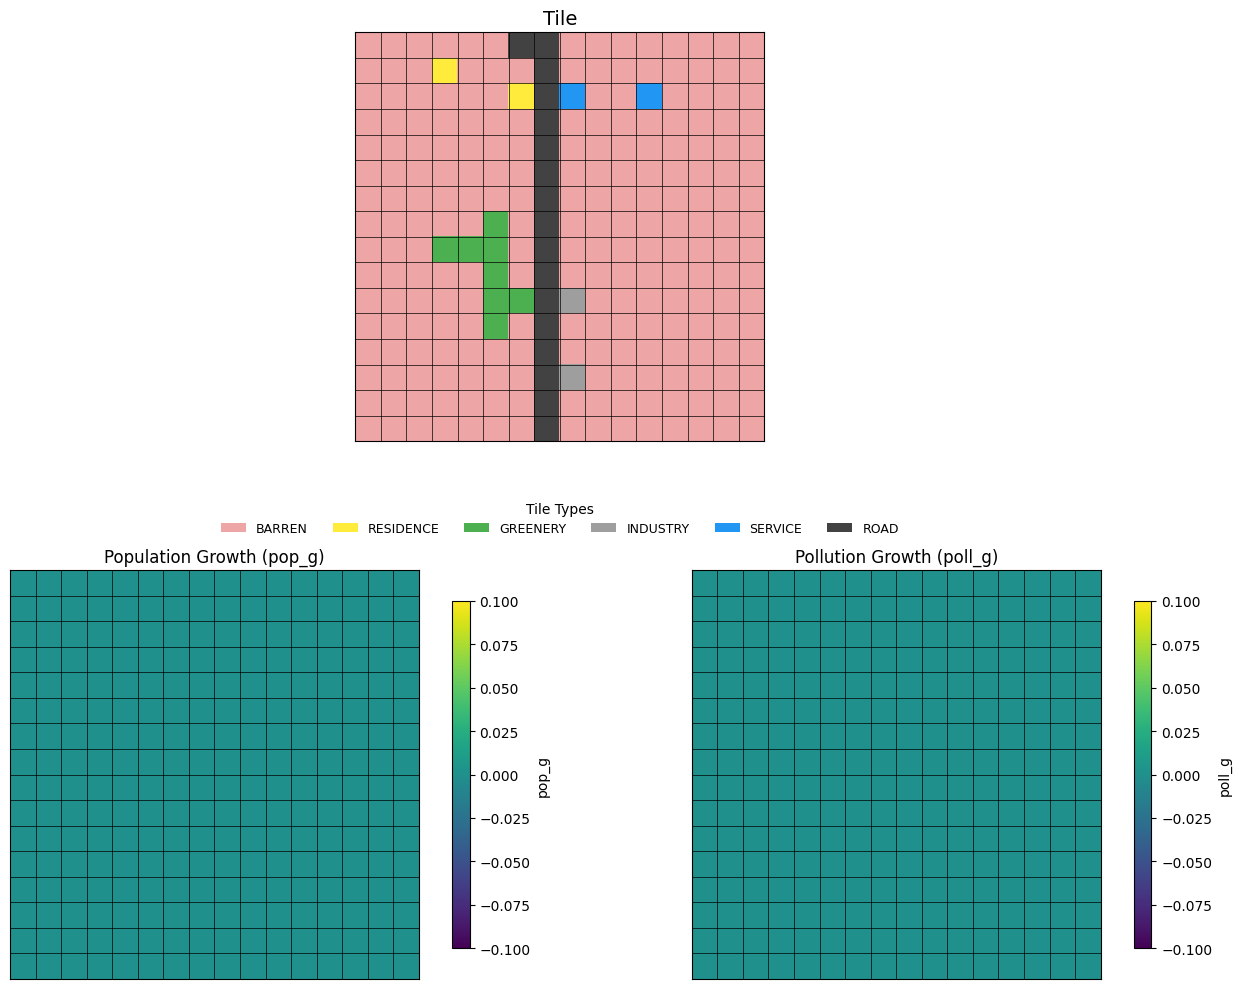

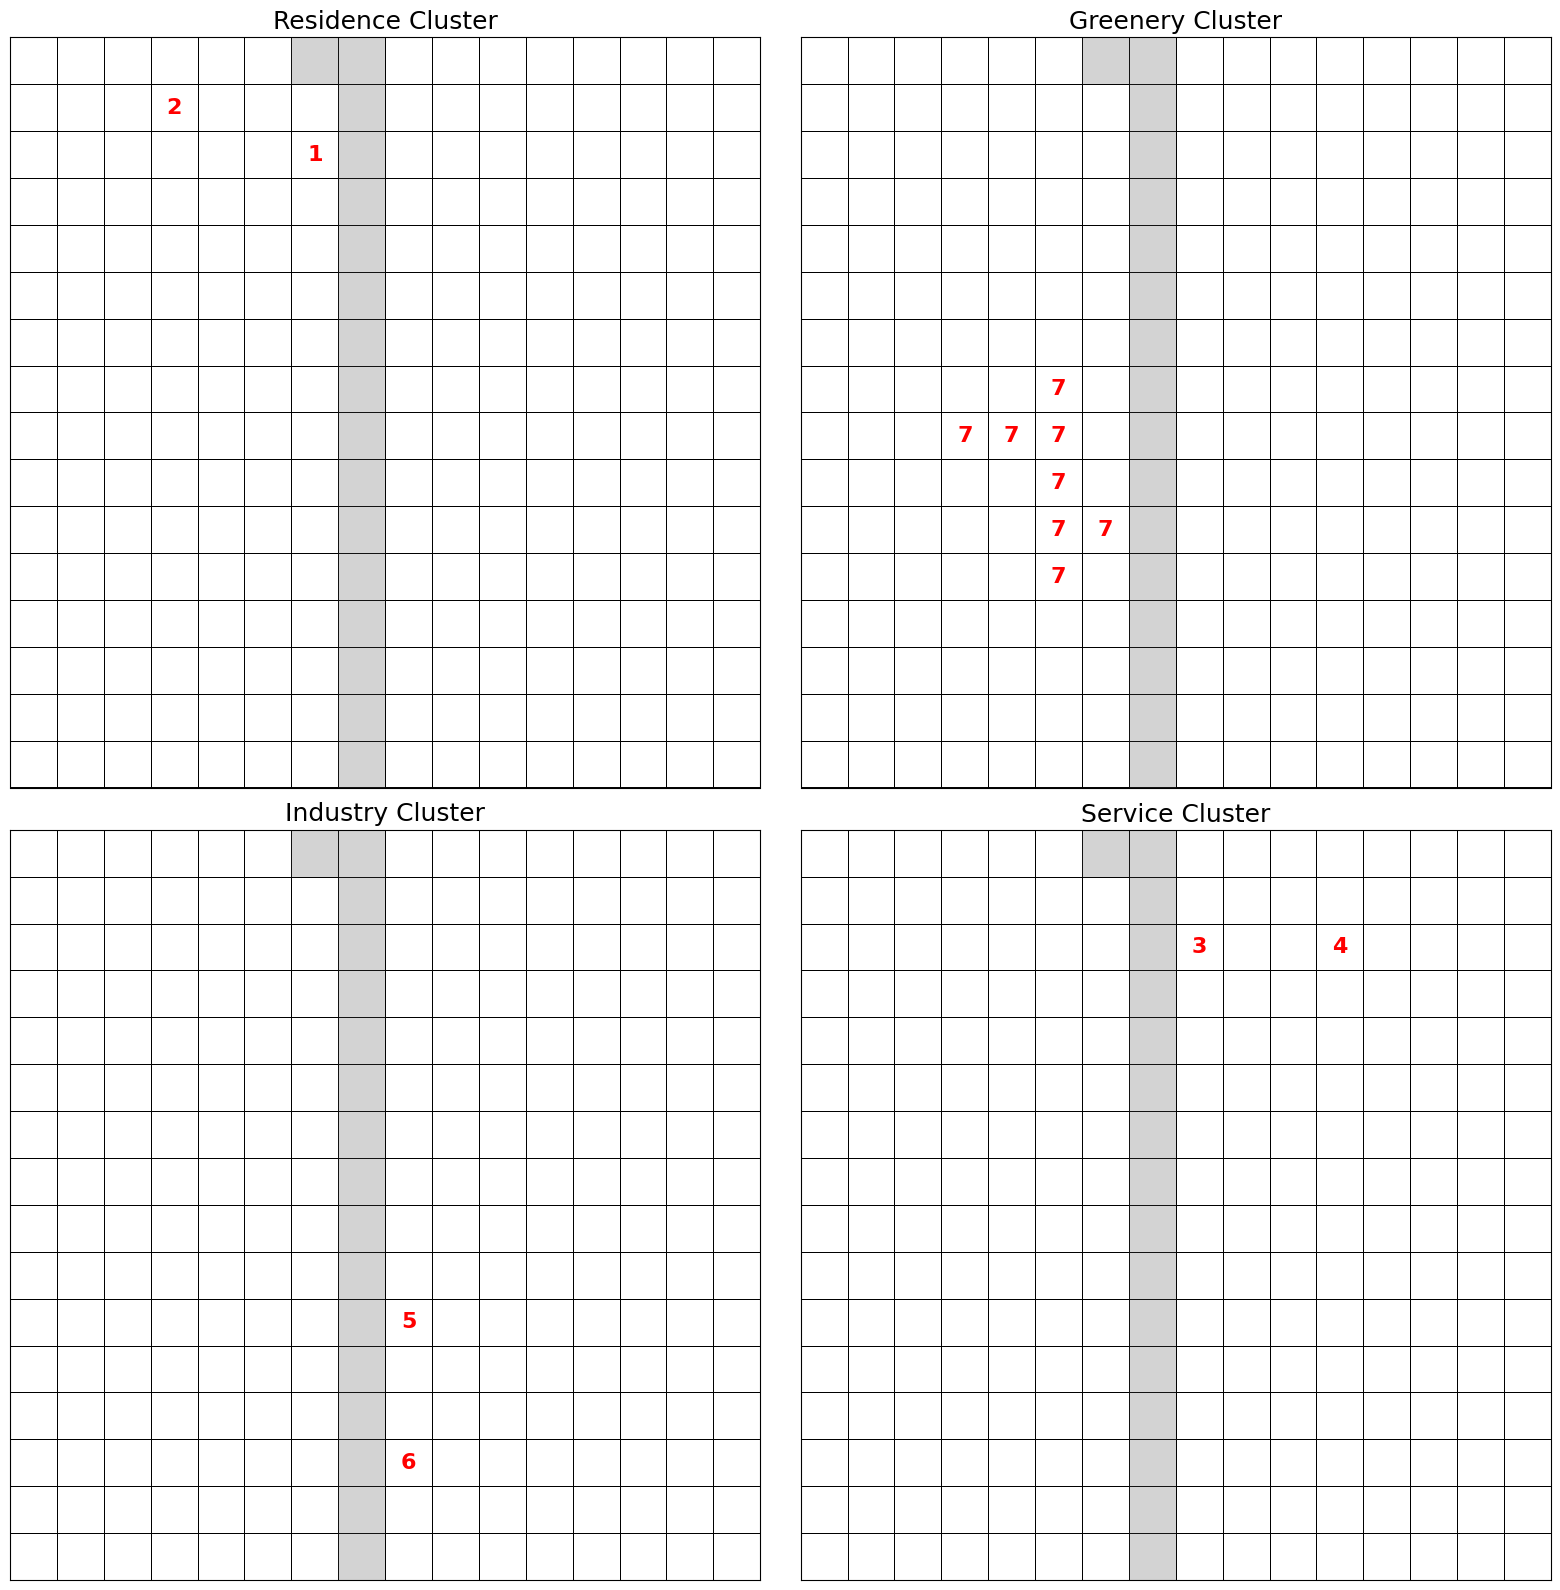

Clusters connected to road
{1, 3, 5, 6, 7}


In [23]:
#add new road tile
model.set_tile(9,5, TileTypes.GREENERY.value)
model.book_keep()

visulise_graph(model)
visualise_tile_cluster(model)

#we can also see what clusters are connected to road
print("Clusters connected to road")
print(model.cluster_adjacent_to_road)

Note cluster 7 had subsumed cluster 8 and clusters adjacent to the road tiles are updated as well.

Road can connect cluster too. Let's go connect cluster 2

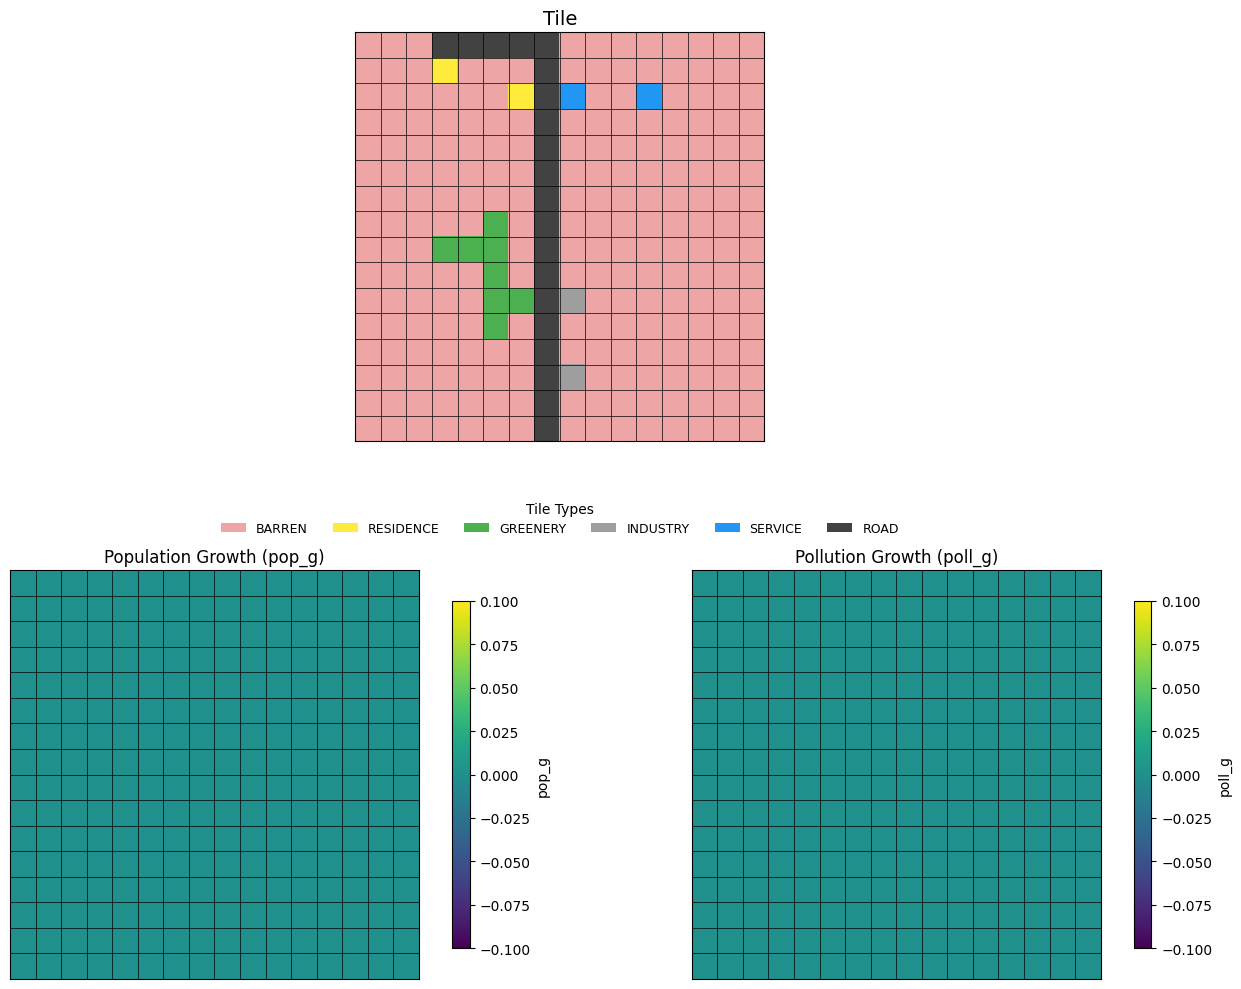

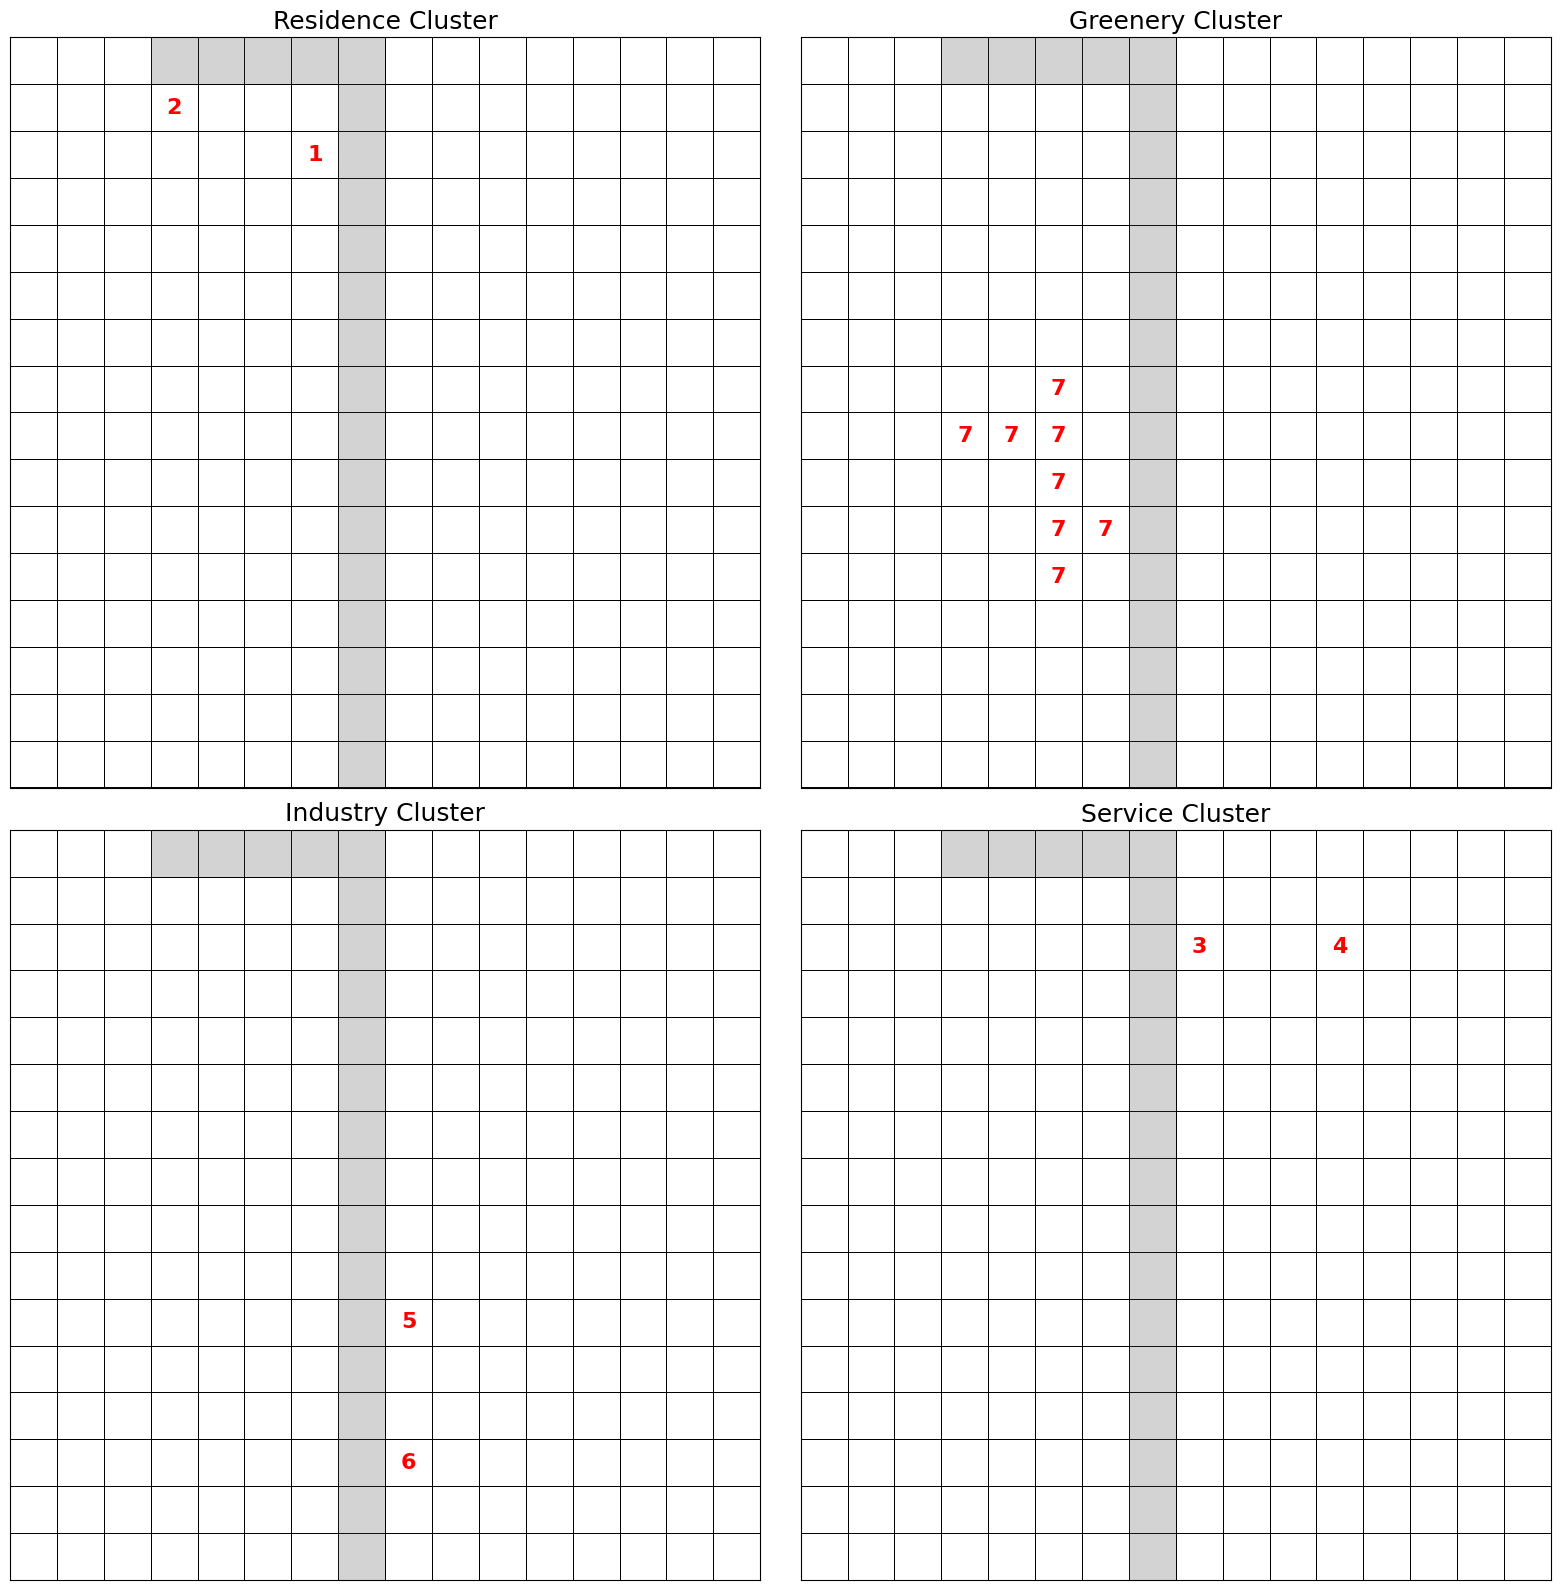

Clusters connected to road
{1, 2, 3, 5, 6, 7}


In [24]:
model.set_tile(0,5, TileTypes.ROAD.value)
model.book_keep()
model.set_tile(0,4, TileTypes.ROAD.value)
model.book_keep()
model.set_tile(0,3, TileTypes.ROAD.value)
model.book_keep()

visulise_graph(model)
visualise_tile_cluster(model)

#we can also see what clusters are connected to road
print("Clusters connected to road")
print(model.cluster_adjacent_to_road)

## Update of Population and Pollution

In general, most mechanics are identical to the base environment, the only difference is connectivity. Any clusters not connected to road are considered deactivated and do not produce pollution/population. Walkabilty is not considered.

Other than that, productivity of service and industry still apply, except for 2 changes: 

- `connectivity_initial_modifier=0`. Productivity still scale with the number of resident tiles connected (which will be via roads.)
- When a tile is operating at >100% productivity, pollution's growth will slow by a factor of 4. For example, if `connectivity_modifier_to_cap=0.2` and residence connected is 20, a service/industry tile will have 4x (20 x 0.2) boost of population, but 1.25x of pollution (1+(20-5) * 0.2/4). This is to simulate that a tile being more efficient as productivity increase, and thus decreasing pollution.
  - This is also for game balancing, connectivity becomes really overpowered once you have  resident superclusters which will create a lot of pollution 

The only exception is Greenery where a disconnected tile will still suppress pollution but not produce population.

In [25]:
#let's see how everything goes

model.update_rules.apply_rules(model)

(60.0, 33.0, 26.287087283425958)

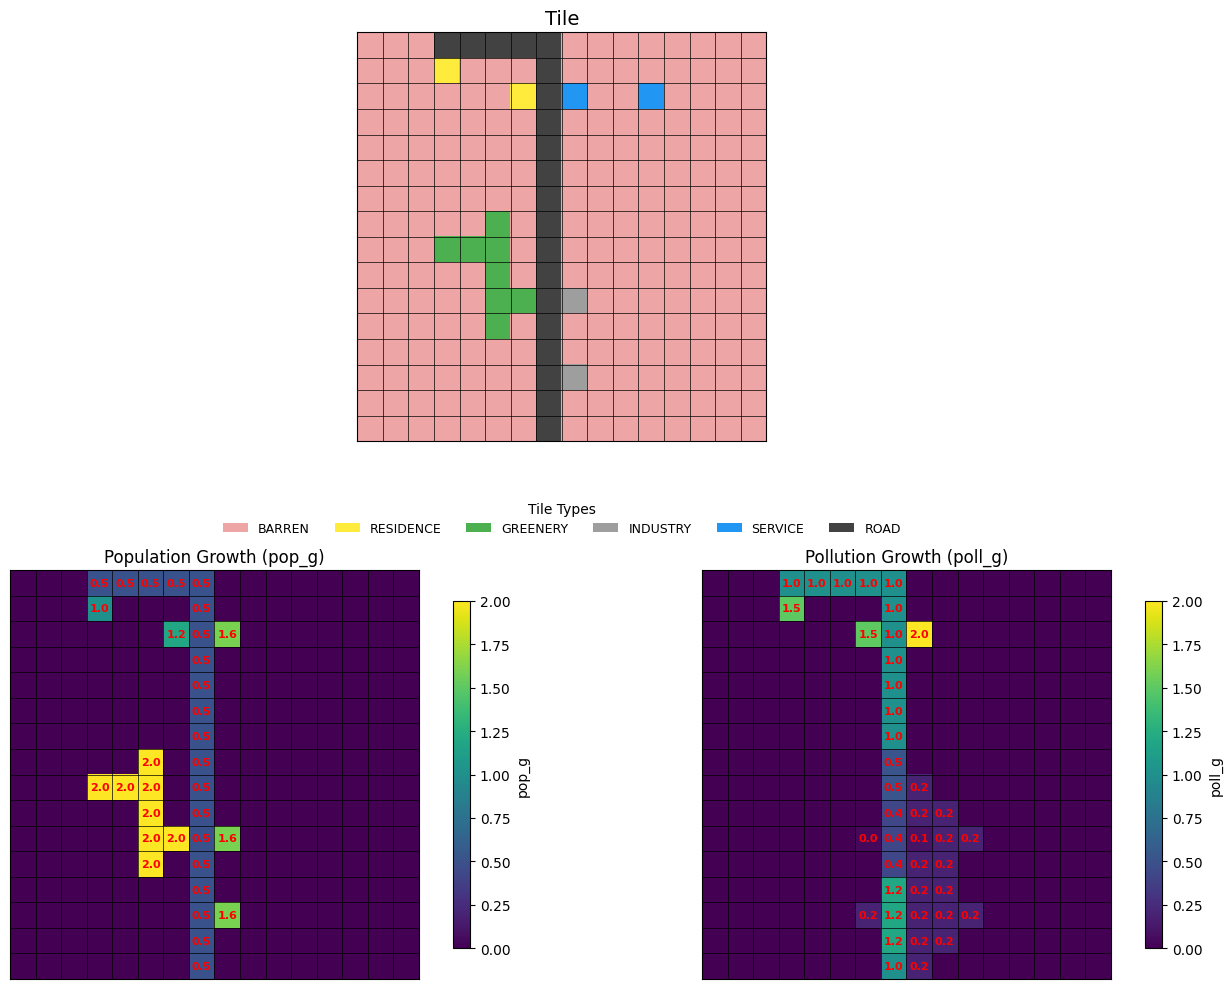

In [26]:
visulise_graph(model)

As we can see one of the residence tile is not counted as it is not connected to the road. Service and industry tiles are connected to the 2 residences and got their relevant boost. In this case, it is coincidental that they both gain 1.6. For residence, 2 * 0.4 * 4, while industry is 2 * 0.2 * 8. 

Now let's add a disconnected tile for greenery.

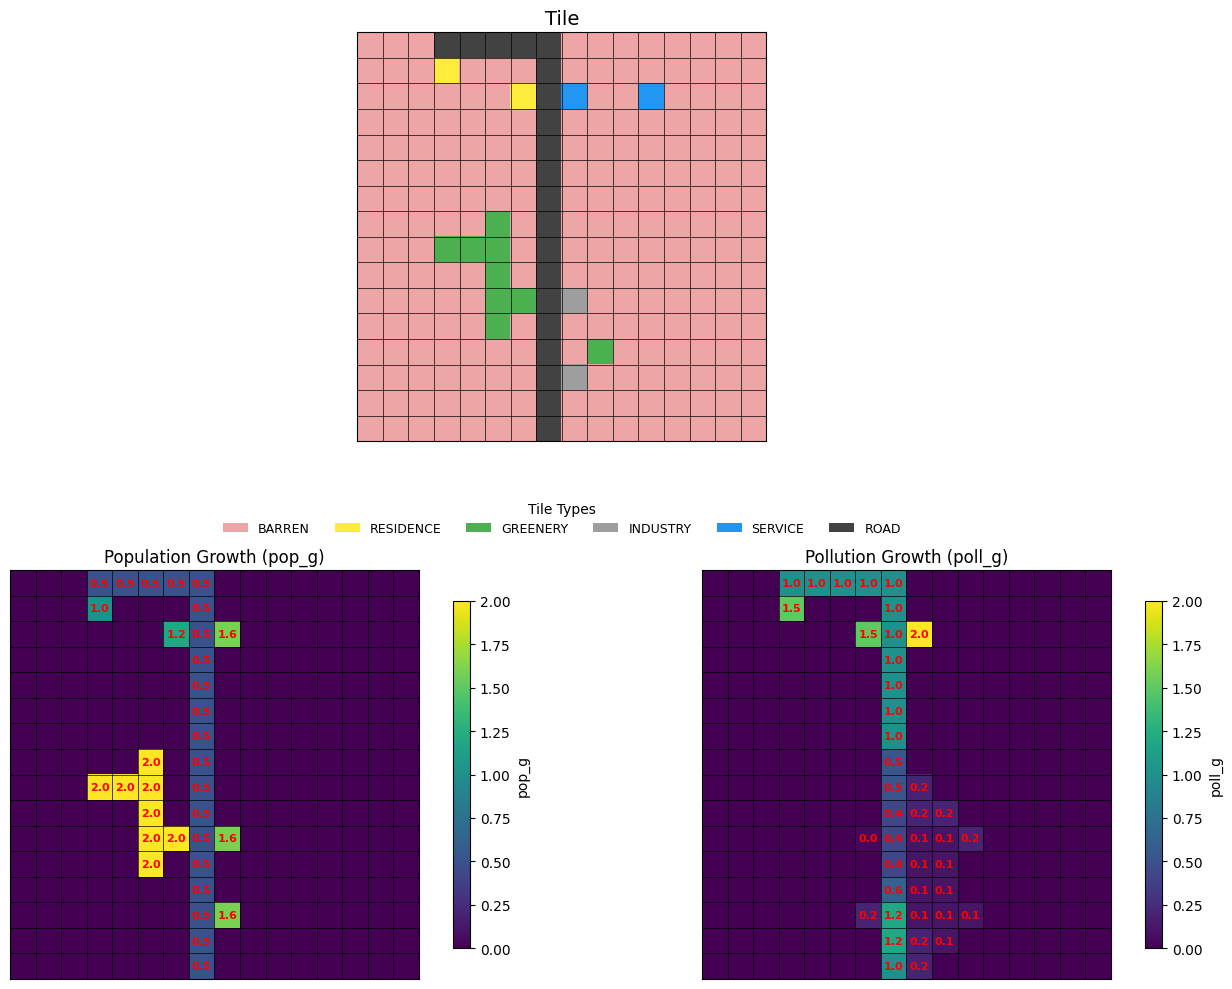

In [27]:
#let's add a disconncted tile of greenery
model.set_tile(12,9, TileTypes.GREENERY.value)
model.book_keep()

model.update_rules.apply_rules(model)
visulise_graph(model)

As we can see, the disconnected greenery does not contribute to population, but they still mitigate in pollution.